In [1]:
import sys
  
# append the path of the
# parent directory
sys.path.append("..")

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import json, csv
import mne
import scipy
import pandas
import copy
import mbt_pyspt as mbt
from mbt_pyspt.models.eegdata import EEGData
from mbt_pyspt.models.mybraineegdata import MyBrainEEGData
from mbt_pyspt.modules.preprocessingflow import PreprocessingFlow
from mbt_pyspt.modules.featuresextractionflow import FeaturesExtractionFlow
from utils.em_data_loader import generate_participants_datasets, generate_participants_events, load_dataset
from utils.em_plotting import plot_annotations, plot_avg_annotations, plot_study, plot_signal, plot_trial_annotations, plot_avg_annotations_all_participants, plot_linear_regression
from preprocessing.em_preprocessing import compute_asr_reconstruction, participant_avg_annotation_windows, preprocess_em_participant, compute_participant_features, remove_baseline
from classification.em_linear_regression import lin_regression, valence_and_neuromarker, arousal_and_neuromarker, liking_familiarity_correlation
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection  import train_test_split
from pprint import pprint
from statistics import mean
from meegkit.asr import ASR
from meegkit.utils.matrix import sliding_window

print("All libraries successfully loaded!")

All libraries successfully loaded!


### Splitting Data
This snippets launches the splitting pipeline that transforms the original datasets in an easy-to-manage set containing only the eeg data and the annotations divided by trials for each participant. Warning: this will overwrite all existing datasets.

In [2]:
# Prepare all the datasets
path_eo_ec = '../data/em_ca_experiment_slim/1EOEC'
path_ec_eo = '../data/em_ca_experiment_slim/2ECEO'
excluded = ['s050702', 's020702', 's060702', 's250603', 's220603', 's220604' 's170603', 's050703', 's050705']
eo_ec_folders = []
ec_eo_folders = []
eeg_folder = 'eeg_raw'
metadata_folder = 'metadata'
physio_folder = 'physio_raw'

for directory in os.listdir(path_eo_ec):
    if directory != 'excluded':
        eo_ec_folders.append(directory)
for directory in os.listdir(path_ec_eo):
    if directory != 'excluded':
        ec_eo_folders.append(directory)

generate_participants_datasets(path_eo_ec, eo_ec_folders, '1EOEC')
generate_participants_datasets(path_ec_eo, ec_eo_folders, '2ECEO')

print("All datasets prepared")

Processing participant s010701
s010701 ...loaded!
s010701 ...generated events!
s010701 ...split data part 1!
s010701 ...split data part 2!
s010701...merged all the data and saved in ../data/em_ca_experiment_slim/1EOEC/s010701/s010701_prepared.json !
Processing participant s010704
s010704 ...loaded!
s010704 ...generated events!
s010704 ...split data part 1!
s010704 ...split data part 2!
s010704...merged all the data and saved in ../data/em_ca_experiment_slim/1EOEC/s010704/s010704_prepared.json !
Processing participant s020701
s020701 ...loaded!
s020701 ...generated events!
s020701 ...split data part 1!
s020701 ...split data part 2!
s020701...merged all the data and saved in ../data/em_ca_experiment_slim/1EOEC/s020701/s020701_prepared.json !
Processing participant s020702
s020702 ...loaded!
s020702 ...generated events!
s020702 ...split data part 1!
s020702 ...split data part 2!
s020702...merged all the data and saved in ../data/em_ca_experiment_slim/1EOEC/s020702/s020702_prepared.json !


s280601 ...loaded!
s280601 ...generated events!
s280601 ...split data part 1!
s280601 ...split data part 2!
s280601...merged all the data and saved in ../data/em_ca_experiment_slim/2ECEO/s280601/s280601_prepared.json !
Processing participant s290601
s290601 ...loaded!
s290601 ...generated events!
s290601 ...split data part 1!
s290601 ...split data part 2!
s290601...merged all the data and saved in ../data/em_ca_experiment_slim/2ECEO/s290601/s290601_prepared.json !
Processing participant s290603
s290603 ...loaded!
s290603 ...generated events!
s290603 ...split data part 1!
s290603 ...split data part 2!
s290603...merged all the data and saved in ../data/em_ca_experiment_slim/2ECEO/s290603/s290603_prepared.json !
Processing participant s290605
s290605 ...loaded!
s290605 ...generated events!
s290605 ...split data part 1!
s290605 ...split data part 2!
s290605...merged all the data and saved in ../data/em_ca_experiment_slim/2ECEO/s290605/s290605_prepared.json !
Processing participant s300604


### Data Loading
Loads the entire dataset in memory and saves the participants keys in an array for later use. Warning: computation is slow and time consuming, use only when necessary.

In [2]:
# Load the entire Emotion-Music dataset
dataset = load_dataset()
participants = dataset.keys()
print(participants)

dict_keys(['s010701', 's010702', 's010703', 's010704', 's020701', 's020702', 's020703', 's020704', 's050701', 's050702', 's050704', 's060703', 's070701', 's070702', 's170601', 's210602', 's220602', 's230602', 's230603', 's230604', 's240601', 's240602', 's240604', 's250601', 's250602', 's250604', 's260601', 's260602', 's280601', 's280603', 's280604', 's290601', 's290602', 's290603', 's290604', 's290605', 's300602', 's300604'])


### Preprocessing 
This code snippet runs the preprocessing pipeline on the whole dataset. Warning: computation is slow and time consuming, use only when necessary.

In [81]:
# Copy the dataset to avoid pre-processing again when data get contaminated
prep_dataset = copy.deepcopy(dataset)

In [90]:
list_pp = [
    #('notch_filter', {"freqs": [50,100]}),
    #('filter_mne', { "l_freq": 0.01, "h_freq": 30}),
    ('remove_dc_sec_by_sec', None), 
    #('median_filter', None),
    #('sliding_split_eeg_data', { 'buf': 5, 'sliding_step': 1}),
    #('interpolate_all_qc', None)
    ]

bpass_freqs = {'l_freq': 0.1, 'h_freq': 20}
notch_freqs = (50, 100)
qi_cleaning = True


    
for participant_id in dataset:
    prep_participant = preprocess_em_participant(prep_dataset[participant_id], list_pp, bpass_freqs=bpass_freqs, notch_freqs=notch_freqs, asr_cleaning=False)
    if qi_cleaning:
        qi_data_removal(prep_participant, trial_duration=60, qi_threshold=0.5)
    prep_dataset[participant_id] = prep_participant

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband

    Range : 0 ... 3249 =      0.000 ...    12.996 secs
Ready.
Clean seconds of annotations: 13.0 13.0
EC/class_2_B
15000
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
Clean seconds of EEG: 57.0
Creating RawArray with float64 data, n_channels=2, n_times=14250
    Range : 0 ... 14249 =      0.000 ...    56.996 secs
Ready.
EO/class_4_A
15000
[0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0]
Clean seconds of EEG: 29.0
Creating RawArray with float64 data, n_channels=2, n_times=7250
    Range : 0 ... 7249 =      0.000 ...    28.996 secs
Ready.
Clean seconds of annotations: 29.0 29.0
EC/class_4_B
15000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 58.0
Creating RawArray with float64 data, n_channels=2, n_times=14500
    Range : 0 ... 14499 =      0


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 7499 =      0.000 ...    29.996 secs
Ready.
Clean seconds of annotations: 30.0 30.0
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
-

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

    Range : 0 ... 14499 =      0.000 ...    57.996 secs
Ready.
EO/class_2_B
15000
[1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0
 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0]
Clean seconds of EEG: 29.0
Creating RawArray with float64 data, n_channels=2, n_times=7250
    Range : 0 ... 7249 =      0.000 ...    28.996 secs
Ready.
Clean seconds of annotations: 29.0 29.0
EC/class_3_A
15000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
EO/class_3_B
15000
[1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0
 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 1]
Clean seconds of EEG: 32.0
Creating RawArray with float64 data, n_channels=2, n_times=8000
    Range : 0 ... 7999 =      0.000 ...    31.996 secs
Ready.
Clean seco


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 13749 =      0.000 ...    54.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- 

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

    Range : 0 ... 749 =      0.000 ...     2.996 secs
Ready.
Clean seconds of annotations: 3.0 3.0
EC/class_1_B
15000
[1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0]
Clean seconds of EEG: 16.0
Creating RawArray with float64 data, n_channels=2, n_times=4000
    Range : 0 ... 3999 =      0.000 ...    15.996 secs
Ready.
EO/class_4_A
15000
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Clean seconds of EEG: 2.0
Creating RawArray with float64 data, n_channels=2, n_times=500
    Range : 0 ... 499 =      0.000 ...     1.996 secs
Ready.
Clean seconds of annotations: 2.0 2.0
EC/class_4_B
15000
[1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Clean seconds of EEG: 3.0
Creating RawArray with float64 data, n_channels=2, n_times=750
    Range : 0 ... 749 =      0.000 ...     2.

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

    Range : 0 ... 11749 =      0.000 ...    46.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- 

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

Clean seconds of EEG: 57.0
Creating RawArray with float64 data, n_channels=2, n_times=14250
    Range : 0 ... 14249 =      0.000 ...    56.996 secs
Ready.
EO/class_4_B
15000
[1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1
 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0]
Clean seconds of EEG: 16.0
Creating RawArray with float64 data, n_channels=2, n_times=4000
    Range : 0 ... 3999 =      0.000 ...    15.996 secs
Ready.
Clean seconds of annotations: 16.0 16.0
EC/class_2_A
15000
[0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
Clean seconds of EEG: 52.0
Creating RawArray with float64 data, n_channels=2, n_times=13000
    Range : 0 ... 12999 =      0.000 ...    51.996 secs
Ready.
EO/class_2_B
15000
[0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0
 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1]
Clean seconds of EEG: 26.0
Creating RawArray with float64 data, n_chann


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-

- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filt

    Range : 0 ... 5499 =      0.000 ...    21.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- U

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Clean seconds of annotations: 15.0 15.0
EC/class_3_B
15000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
EO/class_2_A
15000
[1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
Clean seconds of EEG: 12.0
Creating RawArray with float64 data, n_channels=2, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    11.996 secs
Ready.
Clean seconds of annotations: 12.0 12.0
EC/class_2_B
15000
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
Clean seconds of EEG: 56.0
Creating RawArray with float64 data, n_channels=2, n_times=14000
    Range : 0 ... 13999 =      0


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 10749 =      0.000 ...    42.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- 

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
EO/class_1_B
15000
[0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0]
Clean seconds of EEG: 46.0
Creating RawArray with float64 data, n_channels=2, n_times=11500
    Range : 0 ... 11499 =      0.000 ...    45.996 secs
Ready.
Clean seconds of annotations: 46.0 46.0
EC/class_2_A
15000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
EO/class_2_B
15000
[0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0]
Clean seconds of EEG: 49.0
Creating RawArray with float64 data, n_channels=2, n_times=12250
    Range : 0 ... 12249 =      0.000 ...    48.996 secs
Ready.
Clean 


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 249 =      0.000 ...     0.996 secs
Ready.
Clean seconds of annotations: 1.0 1.0
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lo

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

    Range : 0 ... -1 =      0.000 ...    -0.004 secs
Ready.
Clean seconds of annotations: 0.0 0.0
EC/class_1_B
15000
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Clean seconds of EEG: 0.0
Creating RawArray with float64 data, n_channels=2, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.004 secs
Ready.
EO/class_4_A
15000
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Clean seconds of EEG: 0.0
Creating RawArray with float64 data, n_channels=2, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.004 secs
Ready.
Clean seconds of annotations: 0.0 0.0
EC/class_4_B
15000
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Clean seconds of EEG: 0.0
Creating RawArray with float64 data, n_channels=2, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.004 secs
Read

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

Ready.
Clean seconds of annotations: 19.0 19.0
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

    Range : 0 ... 7999 =      0.000 ...    31.996 secs
Ready.
Clean seconds of annotations: 32.0 32.0
EC/class_1_B
15000
[0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1
 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1]
Clean seconds of EEG: 19.0
Creating RawArray with float64 data, n_channels=2, n_times=4750
    Range : 0 ... 4749 =      0.000 ...    18.996 secs
Ready.
EO/class_2_A
15000
[1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 1
 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0]
Clean seconds of EEG: 31.0
Creating RawArray with float64 data, n_channels=2, n_times=7750
    Range : 0 ... 7749 =      0.000 ...    30.996 secs
Ready.
Clean seconds of annotations: 31.0 31.0
EC/class_2_B
15000
[0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0]
Clean seconds of EEG: 37.0
Creating RawArray with float64 data, n_channels=2, n_times=9250
    Range : 0 ... 9249 =      0.000


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 1999 =      0.000 ...     7.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- U

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

    Range : 0 ... 14499 =      0.000 ...    57.996 secs
Ready.
EO/class_3_B
15000
[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 1
 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1]
Clean seconds of EEG: 19.0
Creating RawArray with float64 data, n_channels=2, n_times=4750
    Range : 0 ... 4749 =      0.000 ...    18.996 secs
Ready.
Clean seconds of annotations: 19.0 19.0
EC/class_2_A
15000
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0]
Clean seconds of EEG: 52.0
Creating RawArray with float64 data, n_channels=2, n_times=13000
    Range : 0 ... 12999 =      0.000 ...    51.996 secs
Ready.
EO/class_2_B
15000
[1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1
 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 0]
Clean seconds of EEG: 22.0
Creating RawArray with float64 data, n_channels=2, n_times=5500
    Range : 0 ... 5499 =      0.000 ...    21.996 secs
Ready.
Clean seco


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 7249 =      0.000 ...    28.996 secs
Ready.
Clean seconds of annotations: 29.0 29.0
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
-

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

    Range : 0 ... 13749 =      0.000 ...    54.996 secs
Ready.
EO/class_2_B
15000
[0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0
 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0]
Clean seconds of EEG: 24.0
Creating RawArray with float64 data, n_channels=2, n_times=6000
    Range : 0 ... 5999 =      0.000 ...    23.996 secs
Ready.
Clean seconds of annotations: 24.0 24.0
EC/class_4_A
15000
[0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0]
Clean seconds of EEG: 50.0
Creating RawArray with float64 data, n_channels=2, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
EO/class_4_B
15000
[1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1
 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1]
Clean seconds of EEG: 27.0
Creating RawArray with float64 data, n_channels=2, n_times=6750
    Range : 0 ... 6749 =      0.000 ...    26.996 secs
Ready.
Clean seco


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 4249 =      0.000 ...    16.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- U

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

    Range : 0 ... 6999 =      0.000 ...    27.996 secs
Ready.
Clean seconds of annotations: 28.0 28.0
EC/class_3_B
15000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
EO/class_1_A
15000
[1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0
 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0]
Clean seconds of EEG: 25.0
Creating RawArray with float64 data, n_channels=2, n_times=6250
    Range : 0 ... 6249 =      0.000 ...    24.996 secs
Ready.
Clean seconds of annotations: 25.0 25.0
EC/class_1_B
15000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Clean seconds of EEG: 59.0
Creating RawArray with float64 data, n_channels=2, n_times=14750
    Range : 0 ... 14749 =      0


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 6499 =      0.000 ...    25.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- U

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

    Range : 0 ... 6999 =      0.000 ...    27.996 secs
Ready.
Clean seconds of annotations: 28.0 28.0
EC/class_1_B
15000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
EO/class_4_A
15000
[1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0
 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0]
Clean seconds of EEG: 25.0
Creating RawArray with float64 data, n_channels=2, n_times=6250
    Range : 0 ... 6249 =      0.000 ...    24.996 secs
Ready.
Clean seconds of annotations: 25.0 25.0
EC/class_4_B
15000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Clean seconds of EEG: 59.0
Creating RawArray with float64 data, n_channels=2, n_times=14750
    Range : 0 ... 14749 =      0


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 11999 =      0.000 ...    47.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- 

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

    Range : 0 ... 14499 =      0.000 ...    57.996 secs
Ready.
EO/class_2_B
15000
[0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 47.0
Creating RawArray with float64 data, n_channels=2, n_times=11750
    Range : 0 ... 11749 =      0.000 ...    46.996 secs
Ready.
Clean seconds of annotations: 47.0 47.0
EC/class_3_A
15000
[1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 51.0
Creating RawArray with float64 data, n_channels=2, n_times=12750
    Range : 0 ... 12749 =      0.000 ...    50.996 secs
Ready.
EO/class_3_B
15000
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
Clean seconds of EEG: 46.0
Creating RawArray with float64 data, n_channels=2, n_times=11500
    Range : 0 ... 11499 =      0.000 ...    45.996 secs
Ready.
Clean 


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 6749 =      0.000 ...    26.996 secs
Ready.
Clean seconds of annotations: 27.0 27.0
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
-

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

Creating RawArray with float64 data, n_channels=2, n_times=3750
    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
EO/class_4_B
15000
[0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1
 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0]
Clean seconds of EEG: 32.0
Creating RawArray with float64 data, n_channels=2, n_times=8000
    Range : 0 ... 7999 =      0.000 ...    31.996 secs
Ready.
Clean seconds of annotations: 32.0 32.0
EC/class_3_A
15000
[0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1]
Clean seconds of EEG: 20.0
Creating RawArray with float64 data, n_channels=2, n_times=5000
    Range : 0 ... 4999 =      0.000 ...    19.996 secs
Ready.
EO/class_3_B
15000
[1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Clean seconds of EEG: 4.0
Creating RawArray with float64 data, n_channels=2, n_times=1000
    Range : 

Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =   

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 8999 =      0.000 ...    35.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- U

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

    Range : 0 ... 14499 =      0.000 ...    57.996 secs
Ready.
EO/class_2_B
15000
[0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1]
Clean seconds of EEG: 10.0
Creating RawArray with float64 data, n_channels=2, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Clean seconds of annotations: 10.0 10.0
EC/class_1_A
15000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 59.0
Creating RawArray with float64 data, n_channels=2, n_times=14750
    Range : 0 ... 14749 =      0.000 ...    58.996 secs
Ready.
EO/class_1_B
15000
[1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0
 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1]
Clean seconds of EEG: 19.0
Creating RawArray with float64 data, n_channels=2, n_times=4750
    Range : 0 ... 4749 =      0.000 ...    18.996 secs
Ready.
Clean seco


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 14749 =      0.000 ...    58.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- 

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

    Range : 0 ... 8999 =      0.000 ...    35.996 secs
Ready.
Clean seconds of annotations: 36.0 36.0
EC/class_2_B
15000
[0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 57.0
Creating RawArray with float64 data, n_channels=2, n_times=14250
    Range : 0 ... 14249 =      0.000 ...    56.996 secs
Ready.
EO/class_1_A
15000
[0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Clean seconds of EEG: 36.0
Creating RawArray with float64 data, n_channels=2, n_times=9000
    Range : 0 ... 8999 =      0.000 ...    35.996 secs
Ready.
Clean seconds of annotations: 36.0 36.0
EC/class_1_B
15000
[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 51.0
Creating RawArray with float64 data, n_channels=2, n_times=12750
    Range : 0 ... 12749 =      0


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 9499 =      0.000 ...    37.996 secs
Ready.
Clean seconds of annotations: 38.0 38.0
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
-

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

    Range : 0 ... 4749 =      0.000 ...    18.996 secs
Ready.
Clean seconds of annotations: 19.0 19.0
EC/class_1_B
15000
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Clean seconds of EEG: 54.0
Creating RawArray with float64 data, n_channels=2, n_times=13500
    Range : 0 ... 13499 =      0.000 ...    53.996 secs
Ready.
EO/class_3_A
15000
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 56.0
Creating RawArray with float64 data, n_channels=2, n_times=14000
    Range : 0 ... 13999 =      0.000 ...    55.996 secs
Ready.
Clean seconds of annotations: 56.0 56.0
EC/class_3_B
15000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =     


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 4499 =      0.000 ...    17.996 secs
Ready.
Clean seconds of annotations: 18.0 18.0
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
-

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

    Range : 0 ... 3749 =      0.000 ...    14.996 secs
Ready.
Clean seconds of annotations: 15.0 15.0
EC/class_2_B
15000
[0 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0]
Clean seconds of EEG: 34.0
Creating RawArray with float64 data, n_channels=2, n_times=8500
    Range : 0 ... 8499 =      0.000 ...    33.996 secs
Ready.
EO/class_4_A
15000
[0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1]
Clean seconds of EEG: 13.0
Creating RawArray with float64 data, n_channels=2, n_times=3250
    Range : 0 ... 3249 =      0.000 ...    12.996 secs
Ready.
Clean seconds of annotations: 13.0 13.0
EC/class_4_B
15000
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1]
Clean seconds of EEG: 45.0
Creating RawArray with float64 data, n_channels=2, n_times=11250
    Range : 0 ... 11249 =      0.0


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

Creating RawArray with float64 data, n_channels=2, n_times=5000
    Range : 0 ... 4999 =      0.000 ...    19.996 secs
Ready.
Clean seconds of annotations: 20.0 20.0
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming win

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000


Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin)

    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Clean seconds of annotations: 10.0 10.0
EC/class_2_B
15000
[0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1]
Clean seconds of EEG: 46.0
Creating RawArray with float64 data, n_channels=2, n_times=11500
    Range : 0 ... 11499 =      0.000 ...    45.996 secs
Ready.
EO/class_3_A
15000
[1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1
 0 0 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1]
Clean seconds of EEG: 21.0
Creating RawArray with float64 data, n_channels=2, n_times=5250
    Range : 0 ... 5249 =      0.000 ...    20.996 secs
Ready.
Clean seconds of annotations: 21.0 21.0
EC/class_3_B
15000
[0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1
 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0]
Clean seconds of EEG: 45.0
Creating RawArray with float64 data, n_channels=2, n_times=11250
    Range : 0 ... 11249 =      0


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 1499 =      0.000 ...     5.996 secs
Ready.
Clean seconds of annotations: 6.0 6.0


In [89]:
def qi_data_removal(participant, trial_duration=60, qi_threshold=1.0, sr=250):
    trials = participant['trials']
    channel_locations = participant['acquisitionLocation']
    for trial in trials:
        if trial.startswith('EO') or trial.startswith('EC'):
            print(trial)
            # find time windows that should be removed according to QI
            
            prep_eeg = participant['trials'][trial]['prep_eeg']
            qualities = participant['trials'][trial]['qualities']
            annotations = participant['trials'][trial]['annotations']
            win_to_remove = np.zeros(trial_duration, dtype=int)
            print(len(prep_eeg.matrix_data[0]))
            iterator = 0
            
            # save the indexes that should be removed. Both channels are iterated and if one of them is below the desired quality, remove both
            for value in qualities[0]:
                if float(value) < qi_threshold:
                    win_to_remove[iterator] = 1
                iterator += 1
            
            iterator = 0
            for value in qualities[1]:
                if float(value) < qi_threshold:
                    win_to_remove[iterator] = 1
                iterator += 1  
            print(win_to_remove) 
            
            # Now loop through the time windows and save the preprocessed EEG in a new variable withouht the low quality data by copying window by window (1 * sampling_rate)
            cleaned_eeg = [[], []]
            idx = 0
            for window in win_to_remove:
                if int(window) == 0:
                    cleaned_eeg[0].extend(prep_eeg.matrix_data[0][idx*sr: idx*sr + sr])
                    cleaned_eeg[1].extend(prep_eeg.matrix_data[1][idx*sr: idx*sr + sr])
                idx += 1
            cleaned_eeg = np.array(cleaned_eeg)
            print("Clean seconds of EEG:", cleaned_eeg.shape[1]/250)
            participant['trials'][trial]['clean_eeg'] = MyBrainEEGData(cleaned_eeg, sr, channel_locations)
            participant['trials'][trial]['c_duration'] = int(cleaned_eeg.shape[1]/250)
            
            # Finally, we also remove the annotations associated with each time window for EO trials
            if trial.startswith('EO'):
                x = []
                y = []
                annotations['c_x'] = []
                annotations['c_y'] = []
                ann_sr = int(len(annotations["x"])/trial_duration)
                #print(len(annotations['x']), len(annotations['y']))
                idx = 0
                for window in win_to_remove:
                    if int(window) == 0:
                        x.extend(annotations['x'][idx*ann_sr: idx*ann_sr + ann_sr])
                        y.extend(annotations['y'][idx*ann_sr: idx*ann_sr + ann_sr])
                    idx += 1
                annotations['c_x'] = x
                annotations['c_y'] = y
                print("Clean seconds of annotations:", len(annotations['c_x'])/ann_sr, len(annotations['c_y'])/ann_sr)
                    

In [ ]:
# DO NOT USE 
# Remove baseline for each trial for each participant
for participant_id in prep_dataset:
    remove_baseline(prep_dataset[participant_id])

### Features Extraction
These snippets extract features and save them in memory as sub entries of each trial

In [24]:
window_size = 5.0
sliding_step = window_size
n_windows = 60.0 / window_size
split_data = {"buf": window_size, "sliding_step": sliding_step}
ff_list = [("get_normalized_power_alpha", {'samp_rate': 250, 'h_freq':13.0, 'l_freq': 7.0})] # , 'ht_freq': 40.0, 'lt_freq': 0.5

for participant_id in prep_dataset:
    compute_participant_features(prep_dataset[participant_id], ff_list=ff_list, split_data=split_data)
    prep_dataset[participant_id] = participant_avg_annotation_windows(prep_dataset[participant_id], n_windows)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ... 

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.00

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.00

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_chann

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_chann

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.00

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.00

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_chann

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_chann

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.00

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.00

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_chann

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_chann

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.00

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.00

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_chann

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_chann

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.00

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.00

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_chan

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_chann

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.0

    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=12, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     4.996 secs
Ready.
Creating RawArray with float64 data, n_chann

In [7]:
print(prep_dataset['s010702']['trials']['EO/class_4_B']['aw_idx'])

[ 0.00586164  0.11509845 -0.0137007   0.01309404  0.04898687  0.02310944
 -0.04855664 -0.01303442 -0.01067172 -0.09848787 -0.01127727 -0.04828906
 -0.03510579 -0.01266361  0.00165196 -0.00574478  0.00453778 -0.01458642
  0.02867119 -0.01727301  0.01547298  0.01499787 -0.0005023   0.00028326
  0.00057457  0.01356515 -0.03517188  0.00585522 -0.01587517 -0.01281742
  0.0092504  -0.00604889  0.00686491 -0.02869908 -0.01094315  0.00461984
  0.00349237  0.00096615 -0.0626118   0.06462412  0.00040609  0.00381157
  0.01687328 -0.07519877 -0.00554739 -0.04600363  0.01233129  0.00644412
 -0.0826161  -0.07009336 -0.04949492 -0.05068781 -0.07798969 -0.00899616
  0.00393025 -0.05601593  0.00650831 -0.03308242 -0.0358691  -0.01877347]


This snippet calculates average annotations for each participant for a specified amount of windows. Since each trial is 60 seconds, setting n_windows = 60 will calculate windows of 1 second

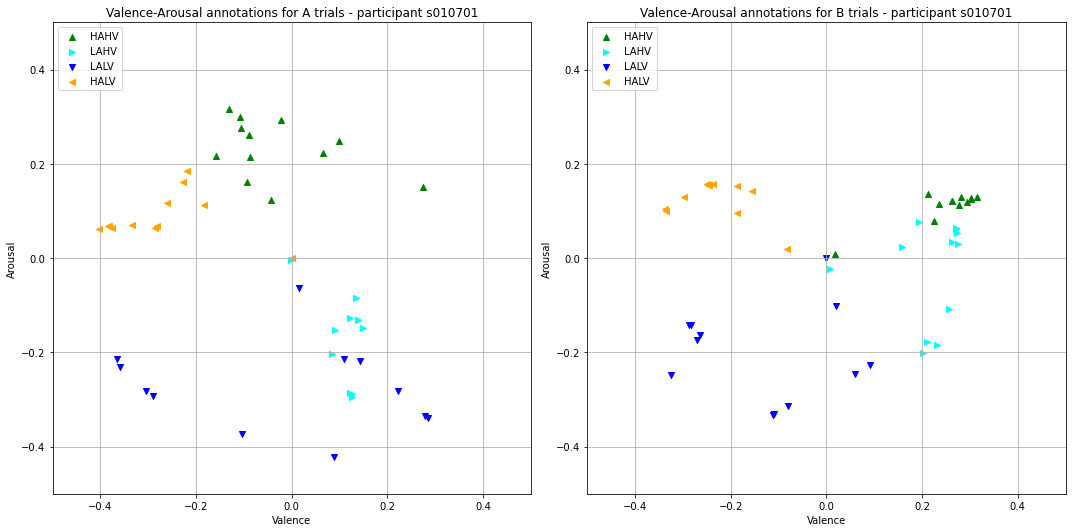

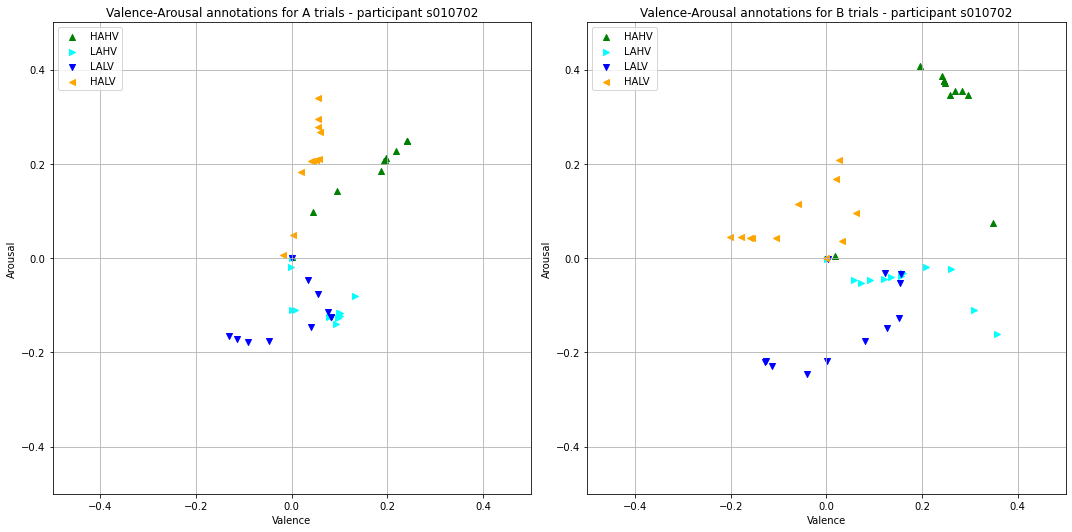

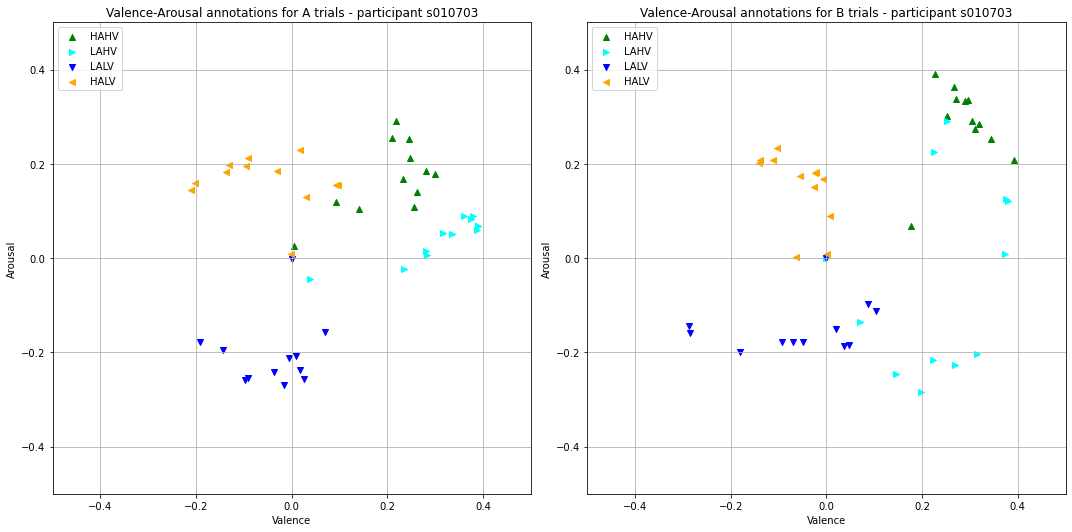

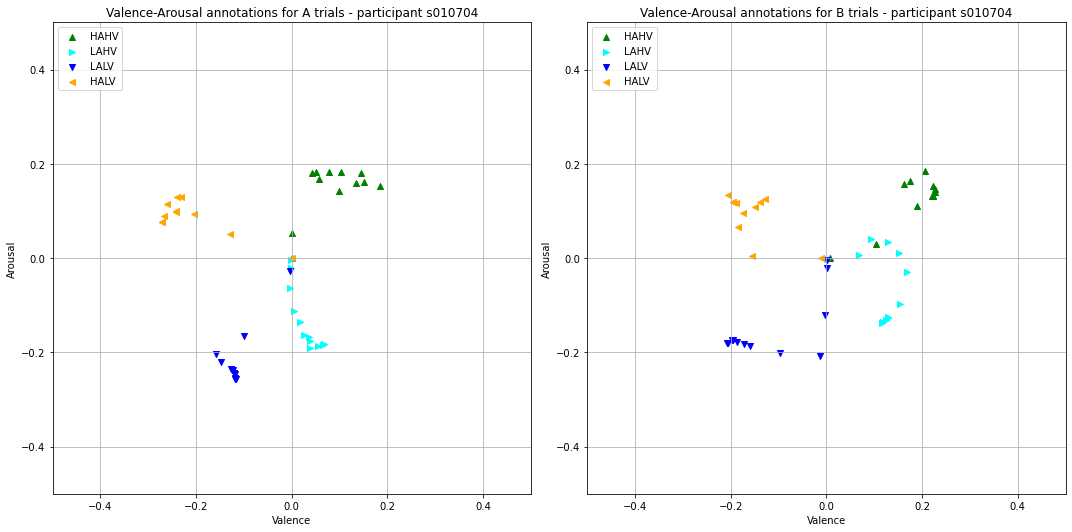

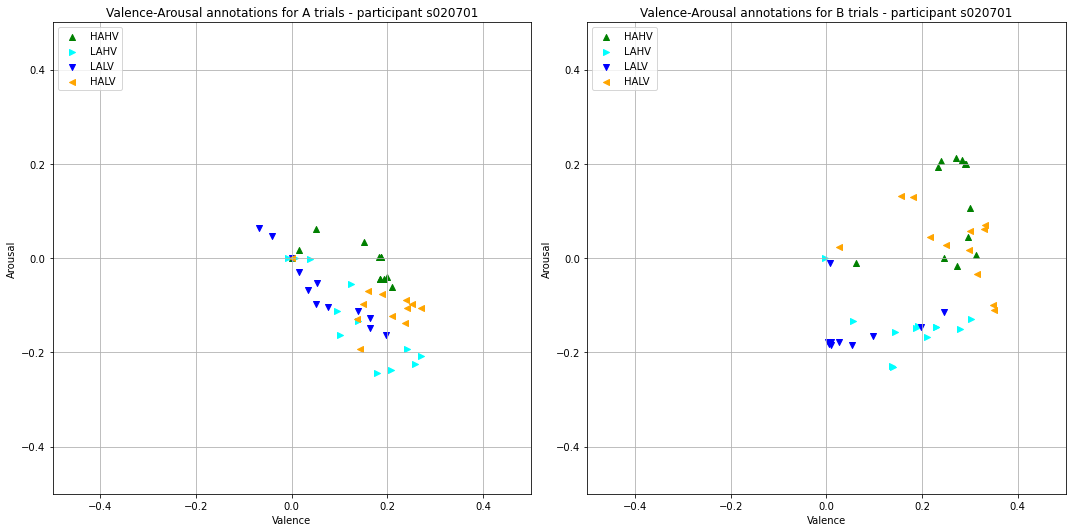

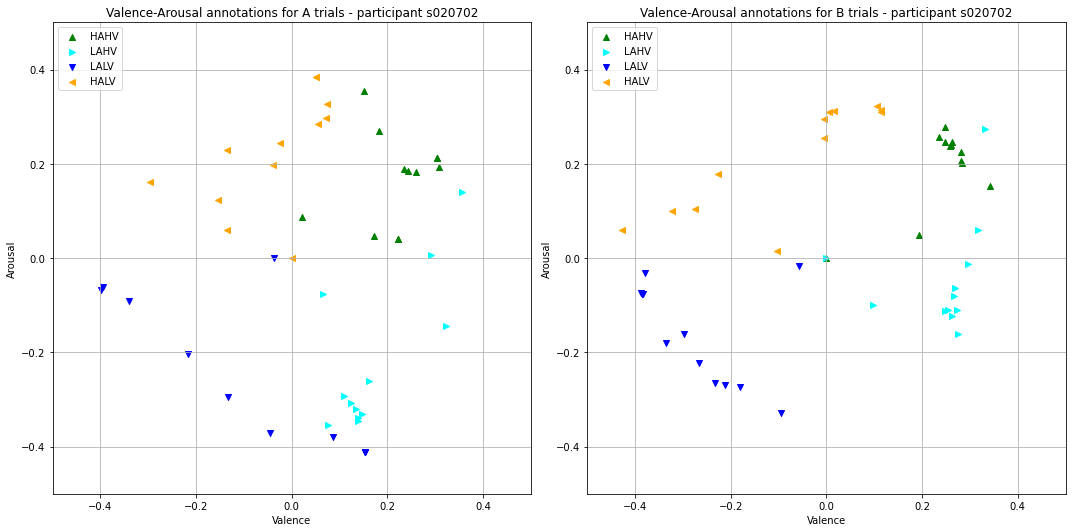

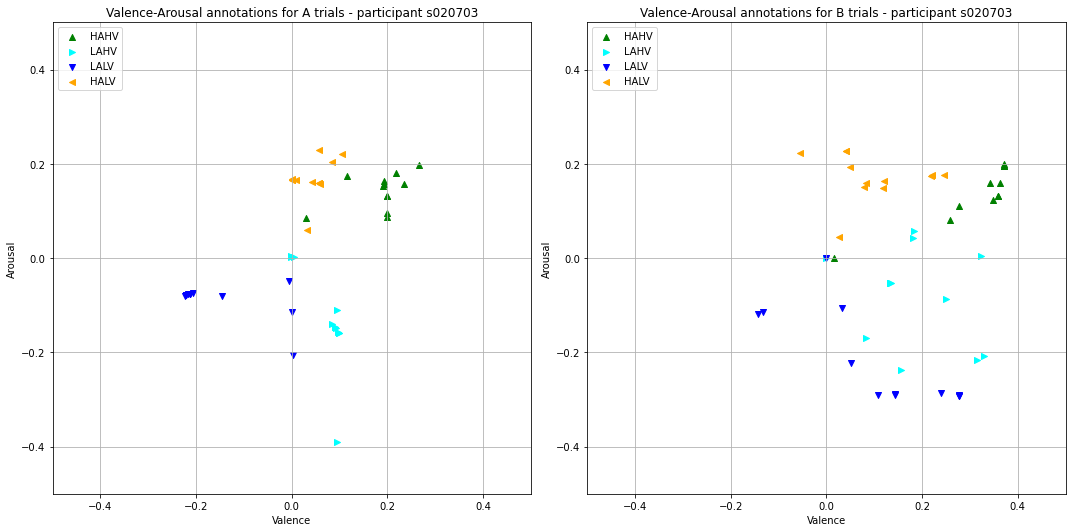

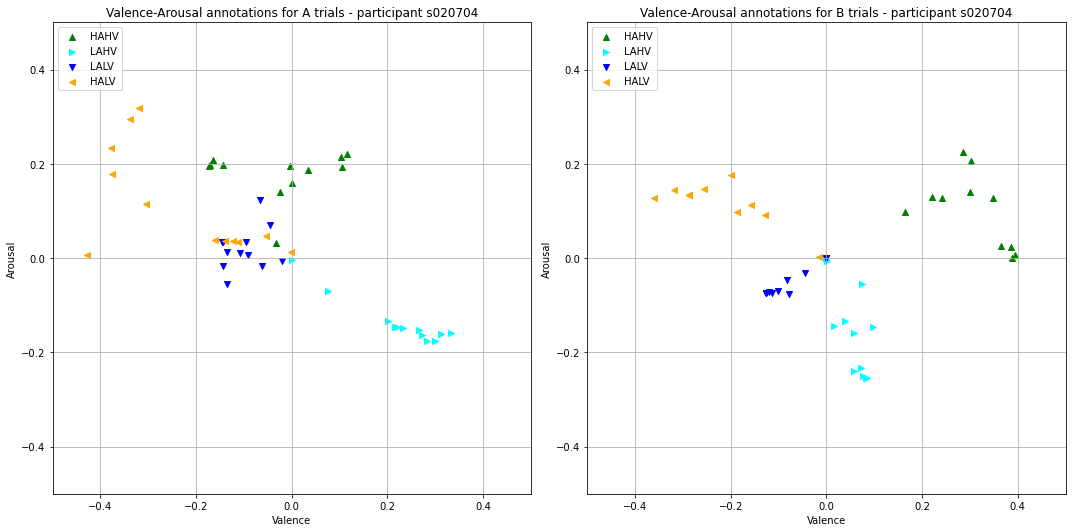

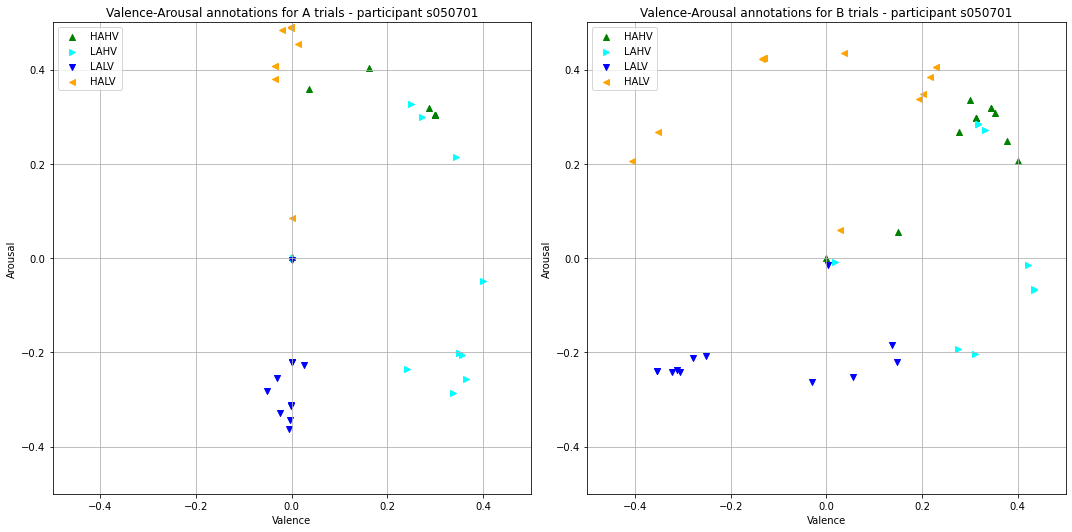

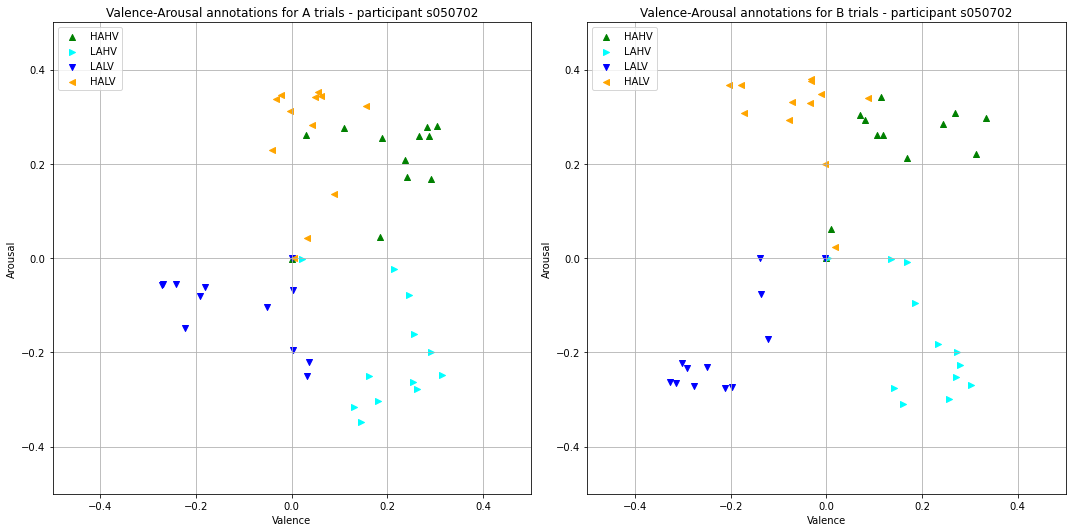

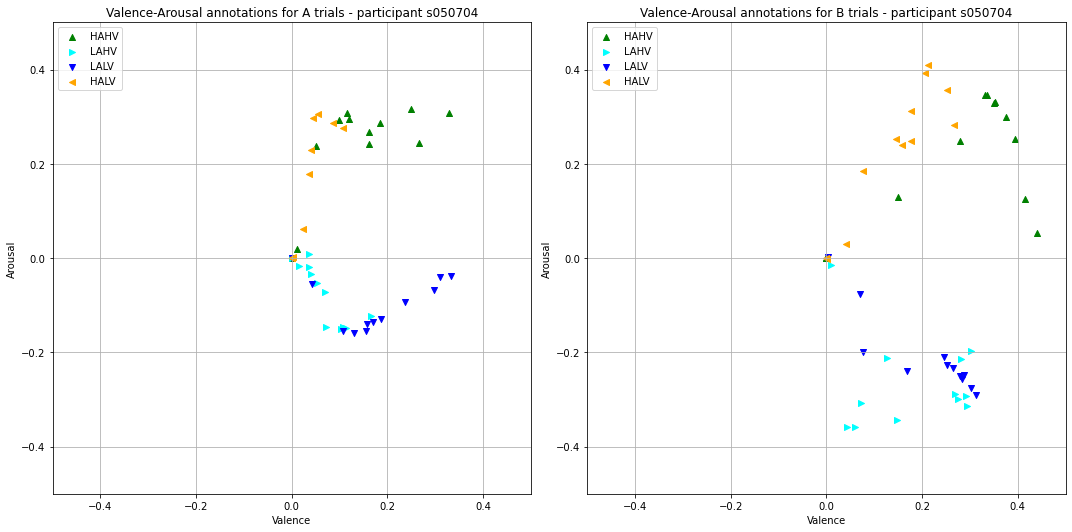

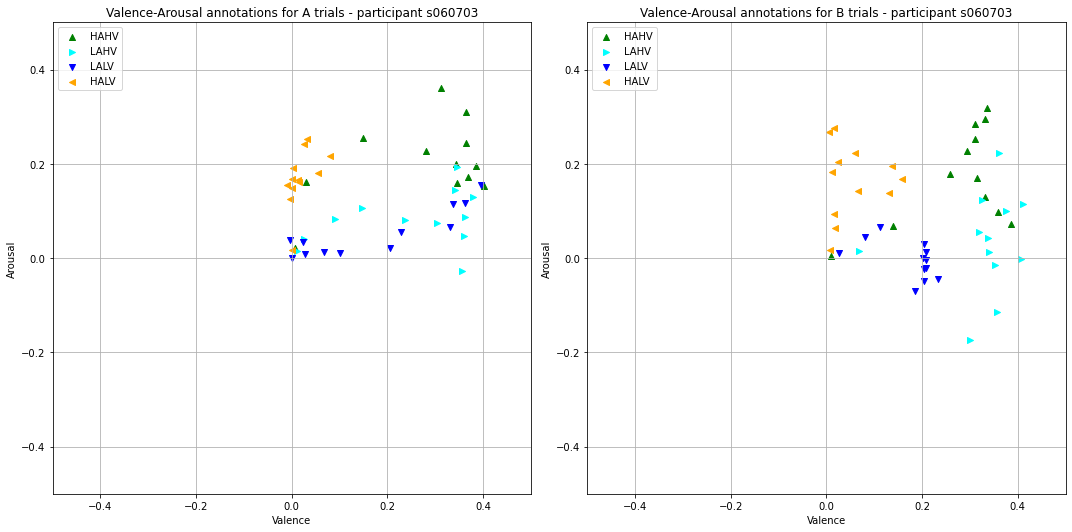

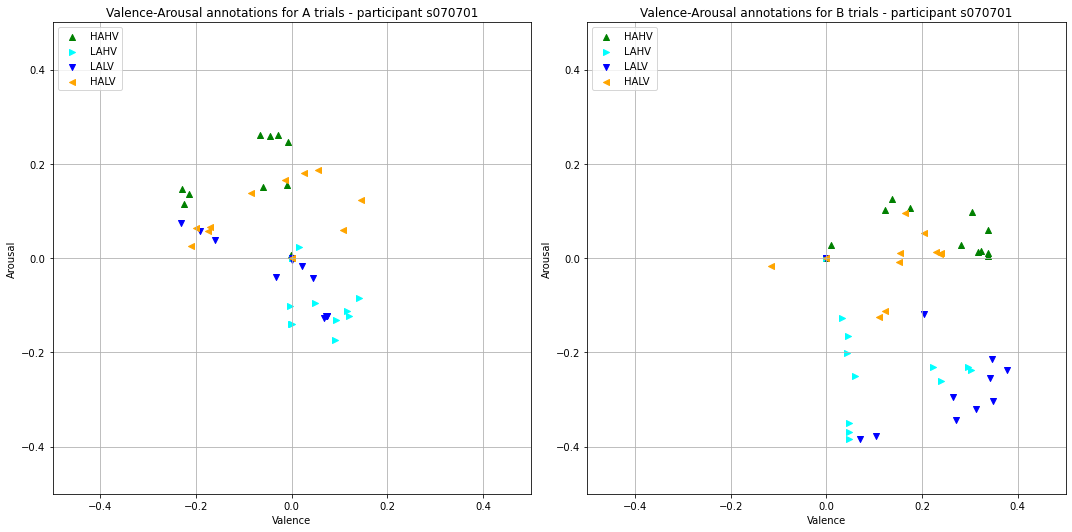

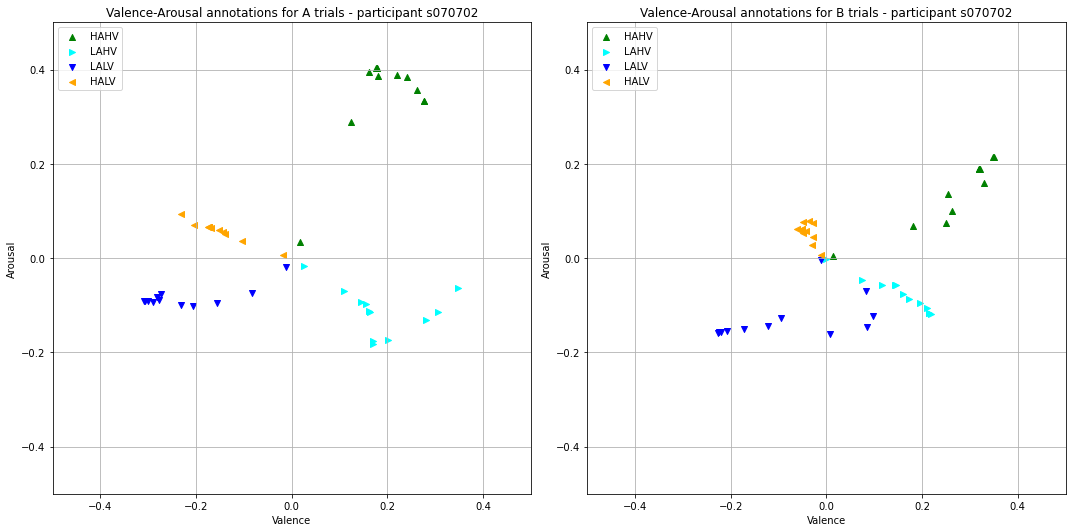

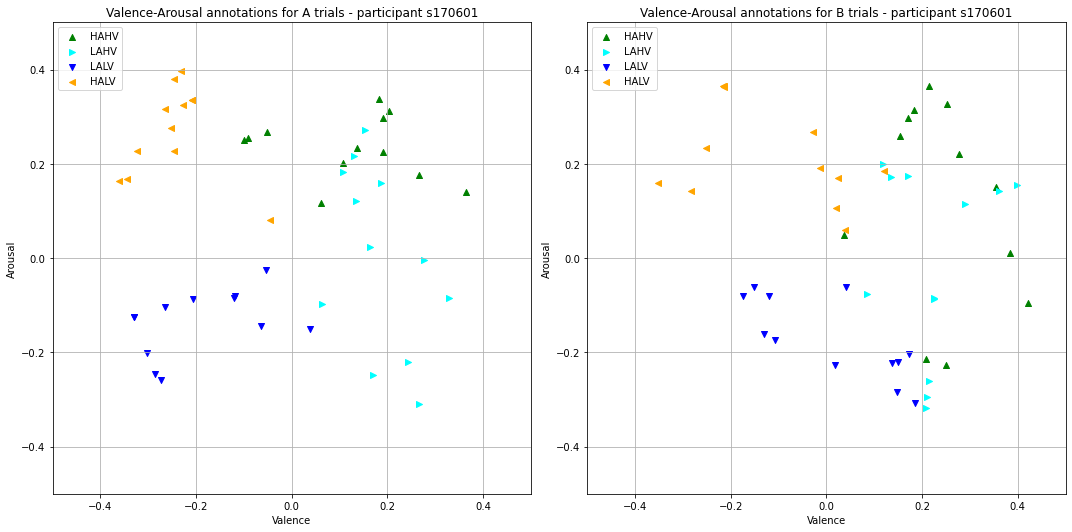

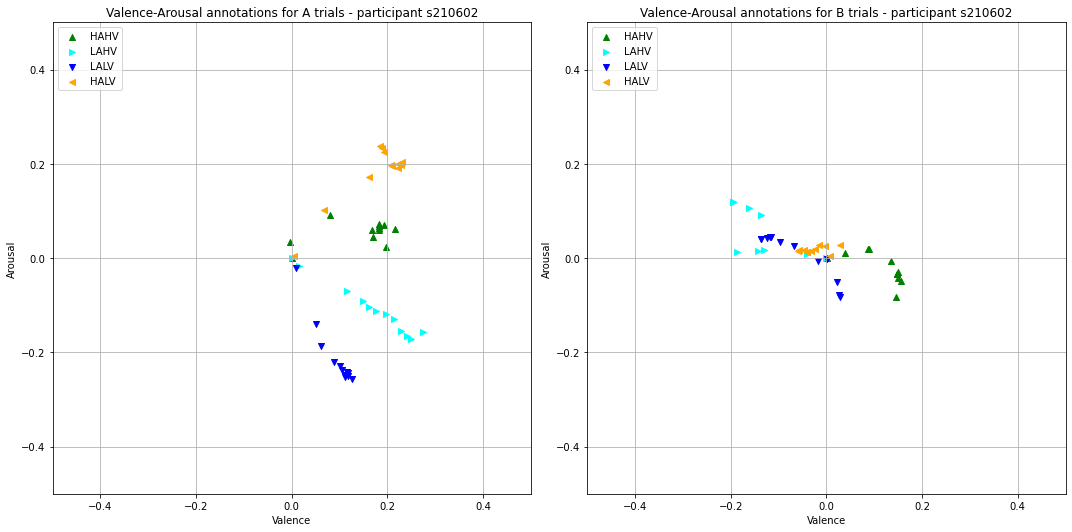

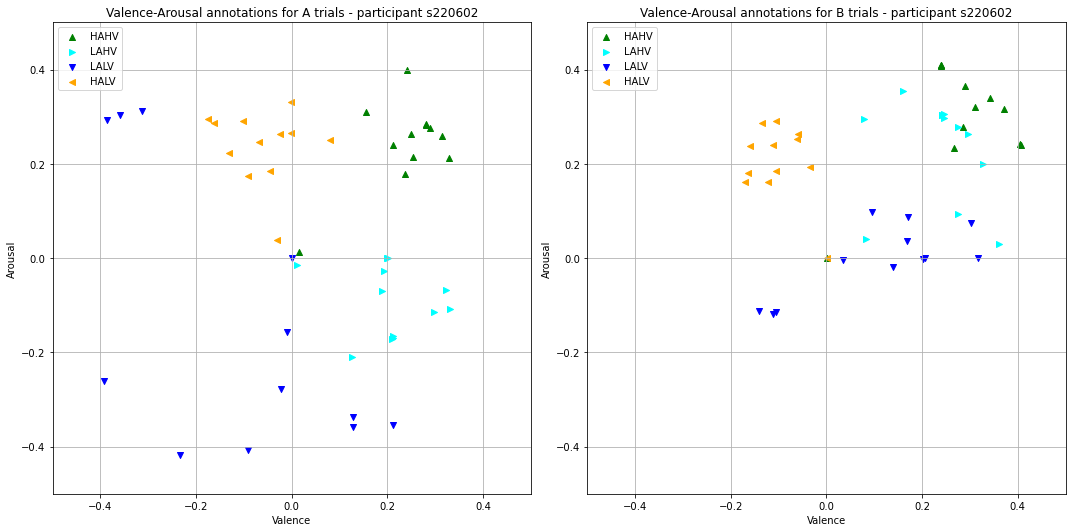

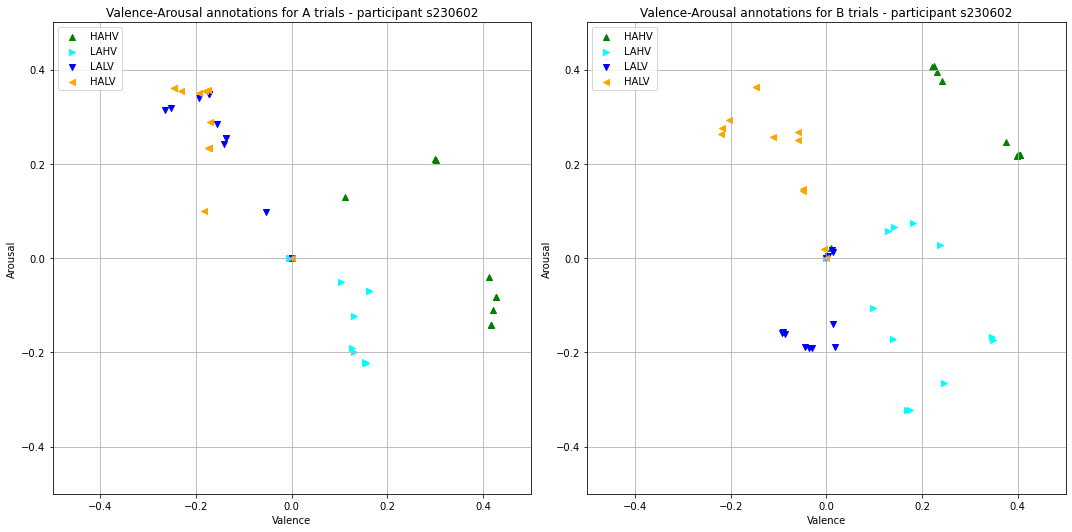

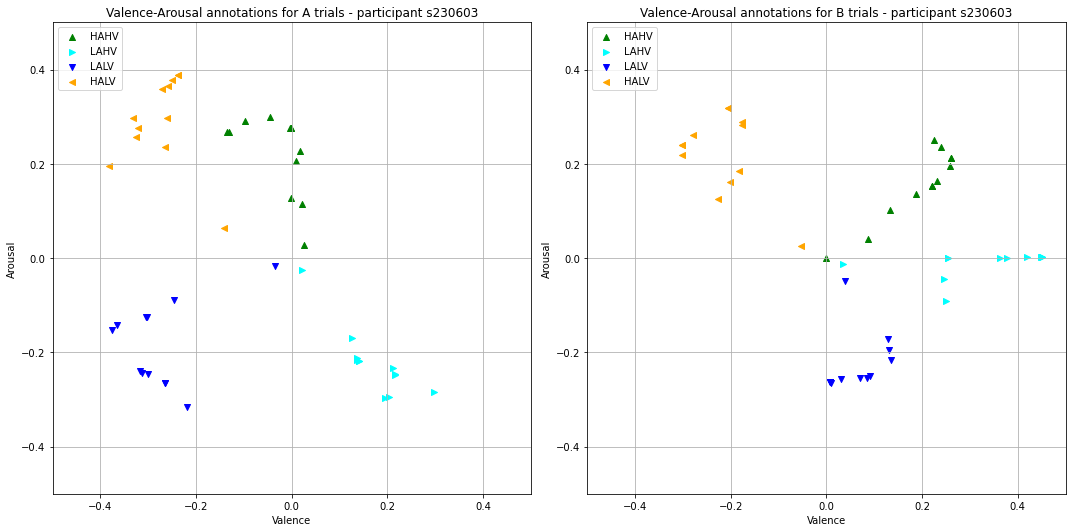

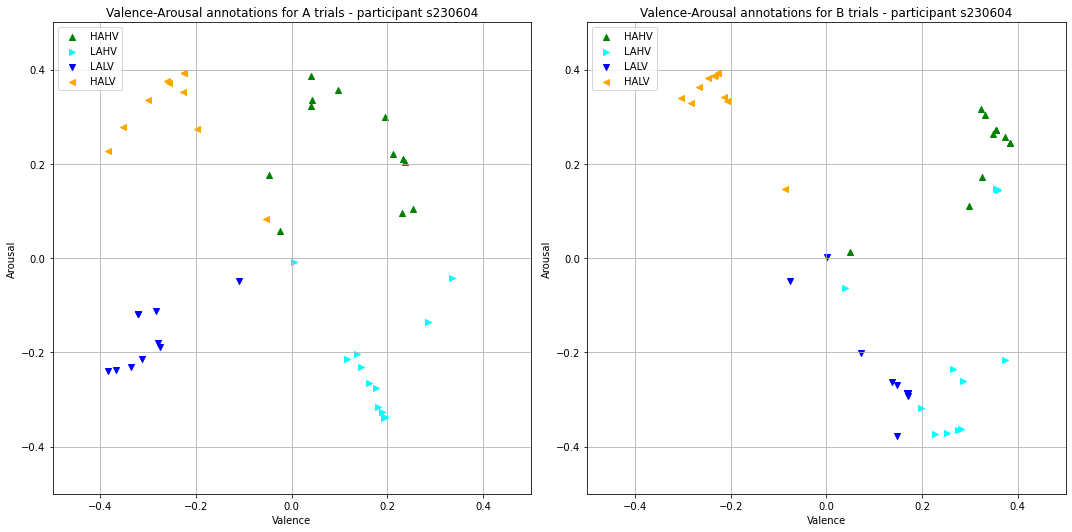

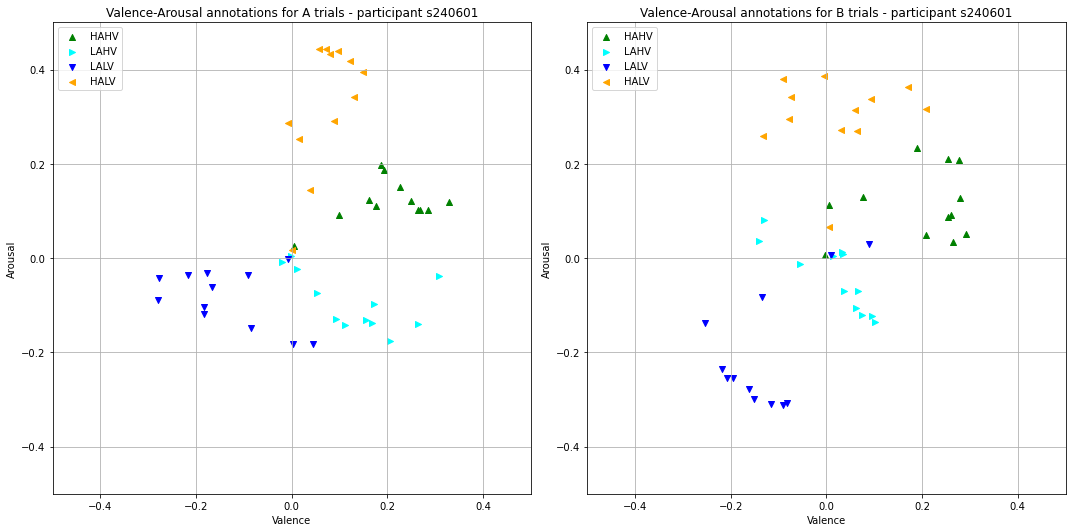

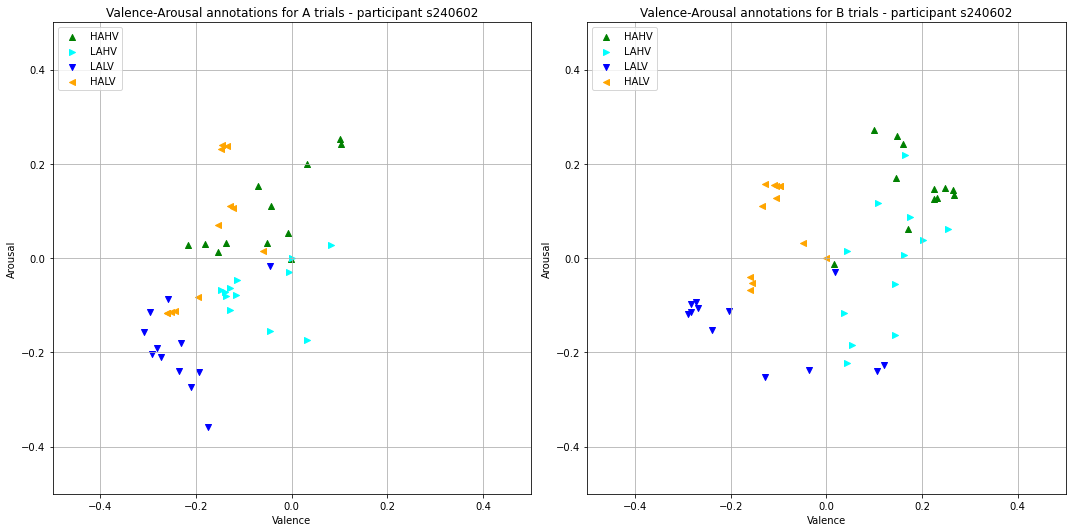

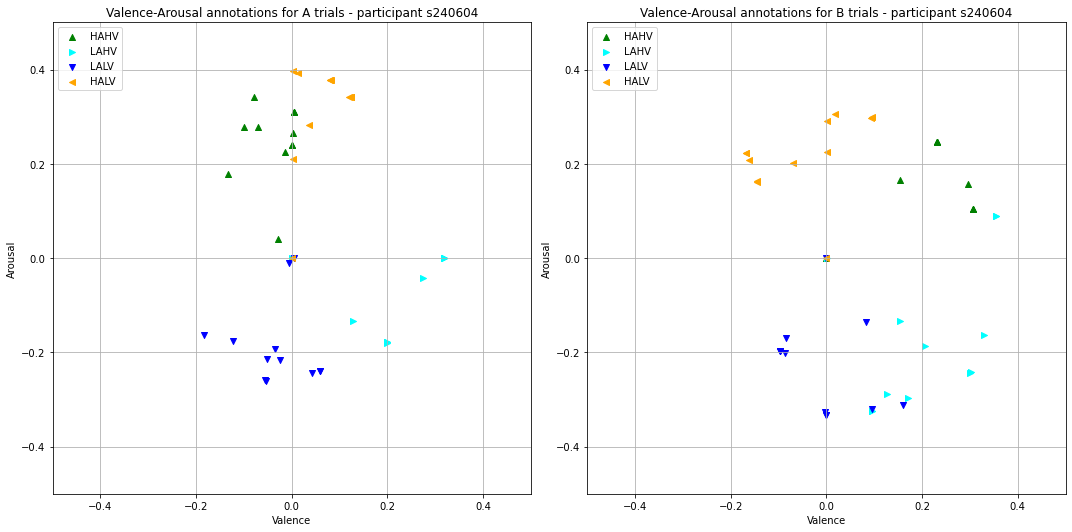

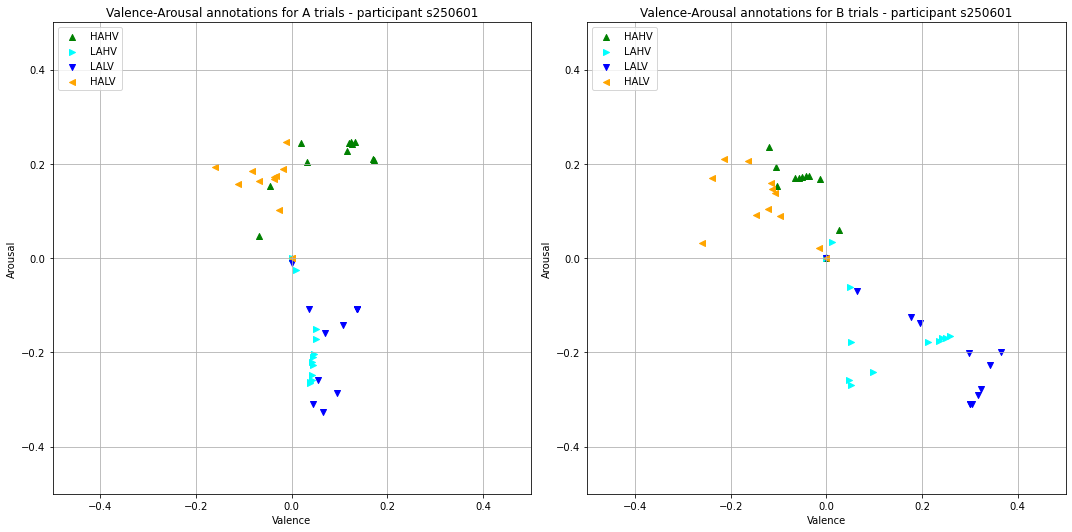

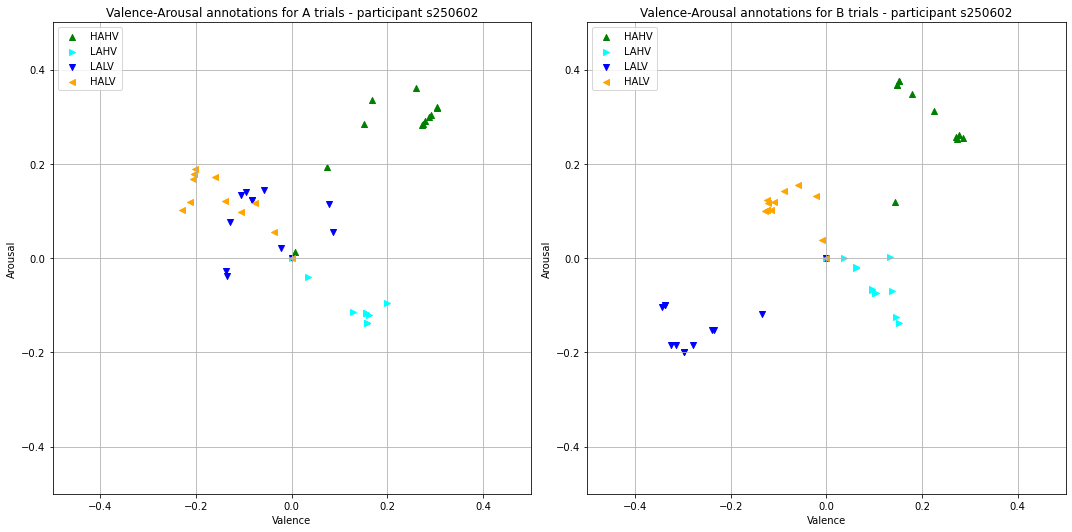

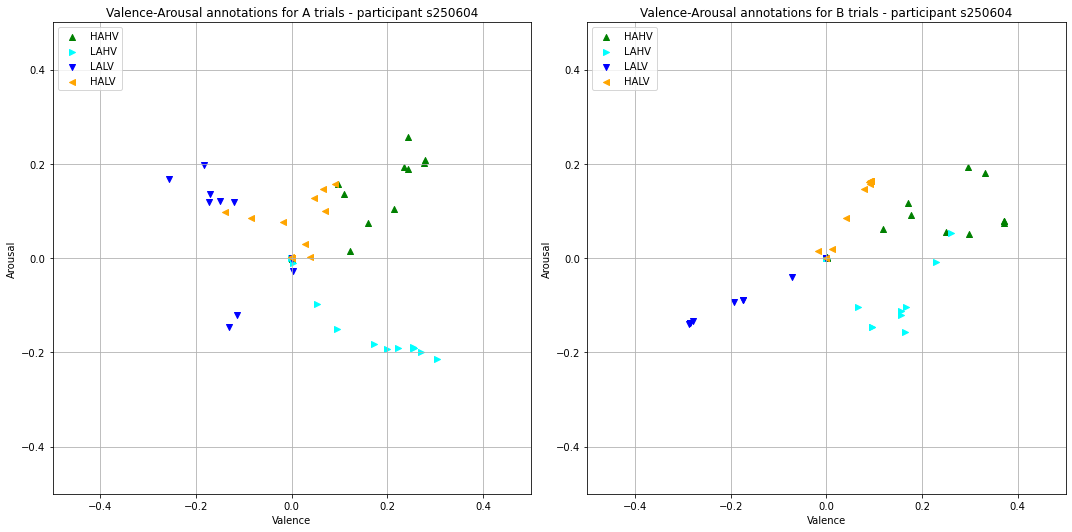

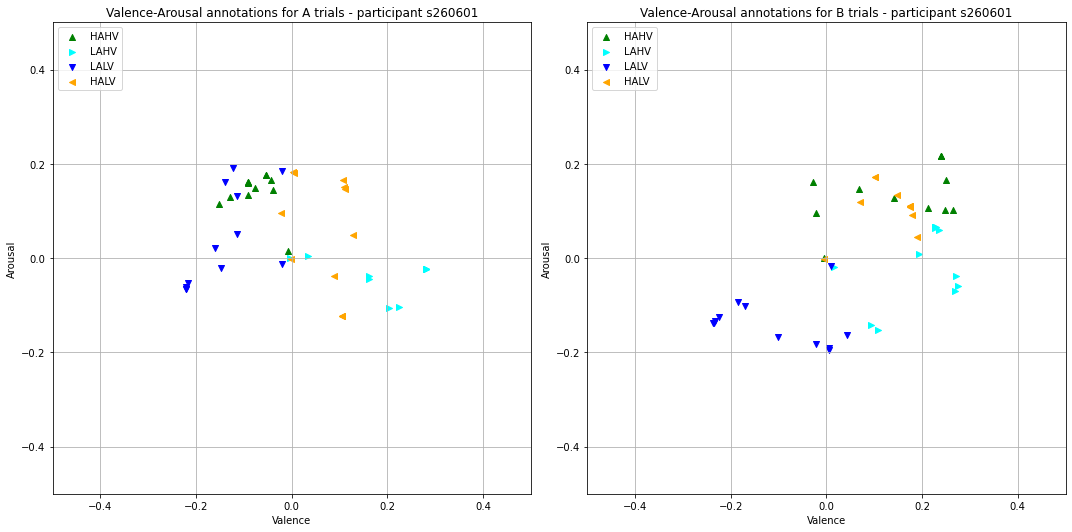

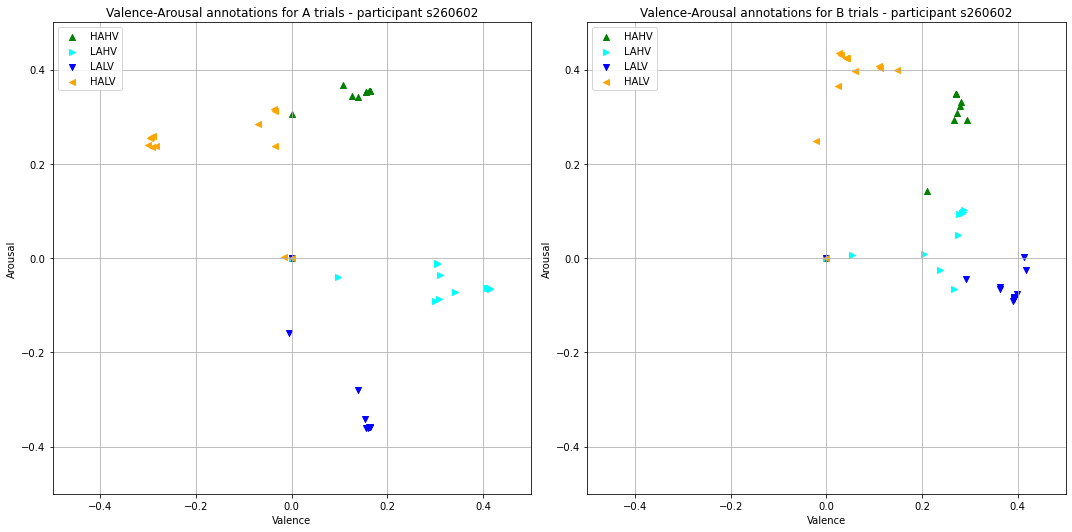

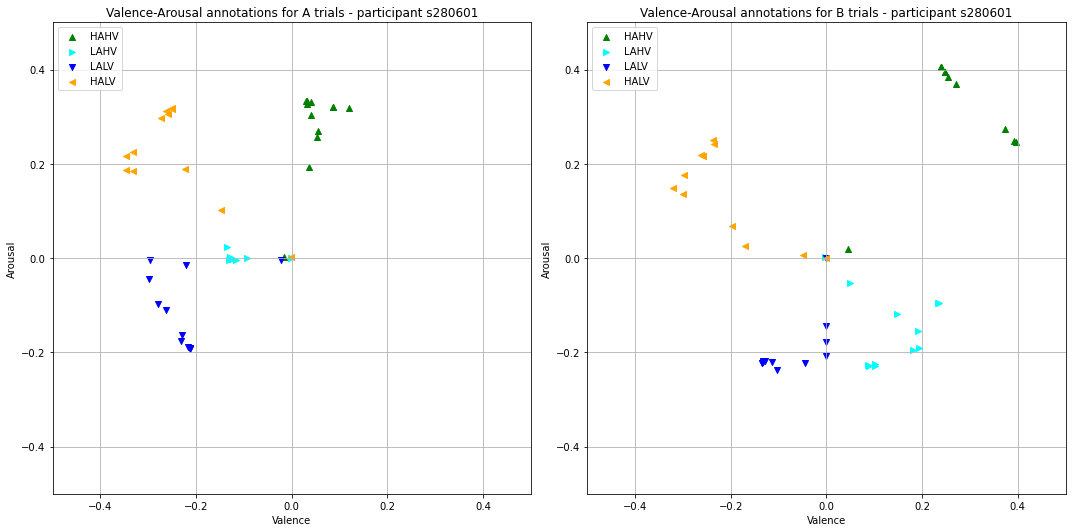

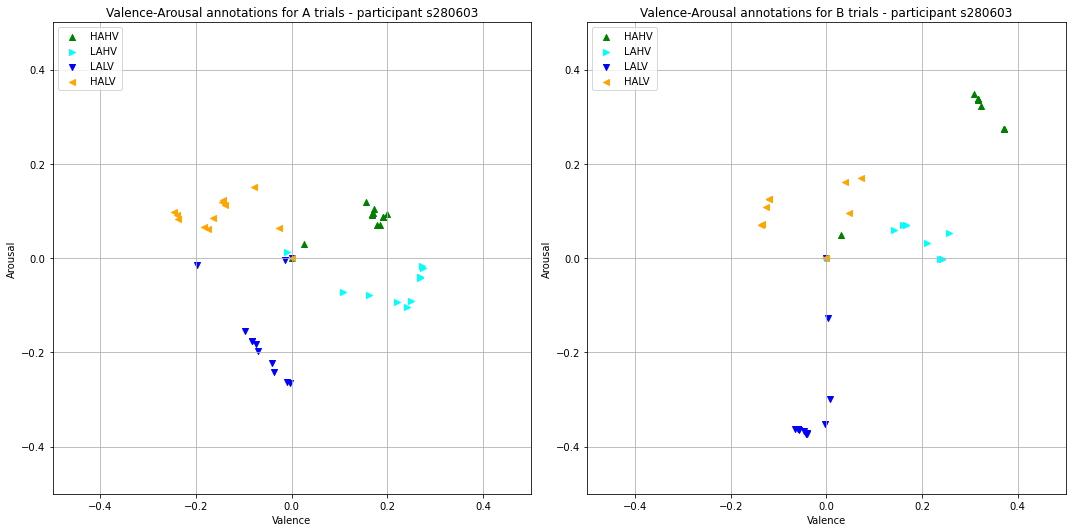

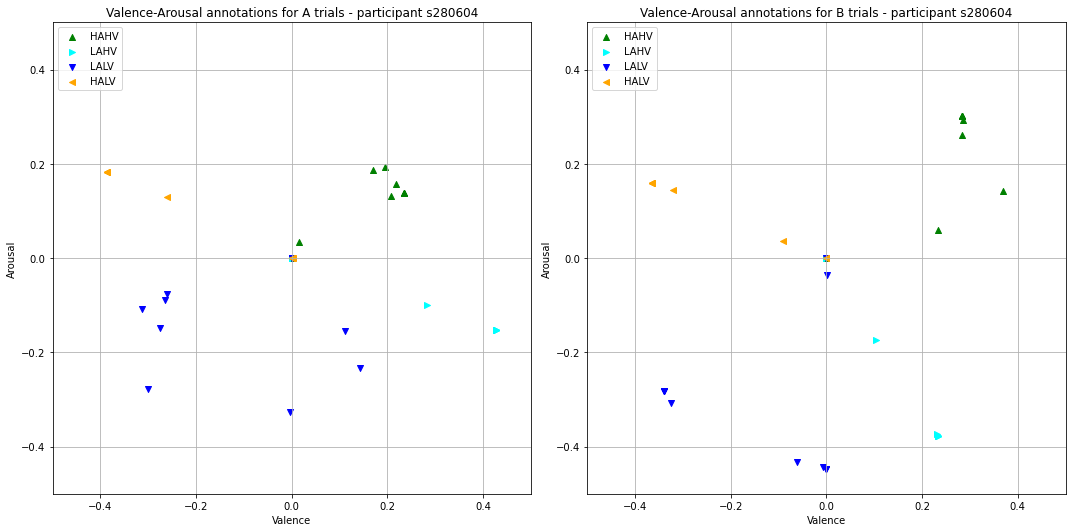

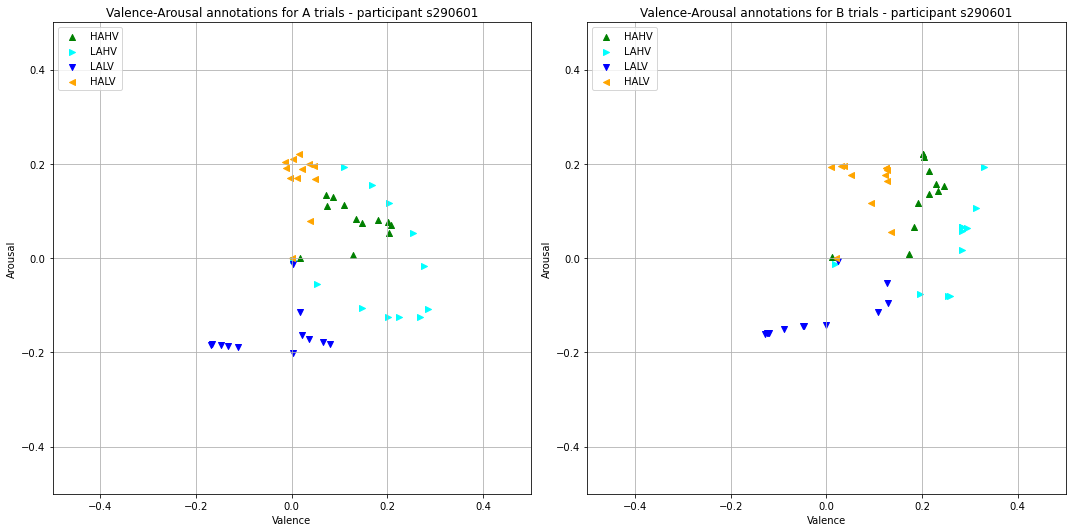

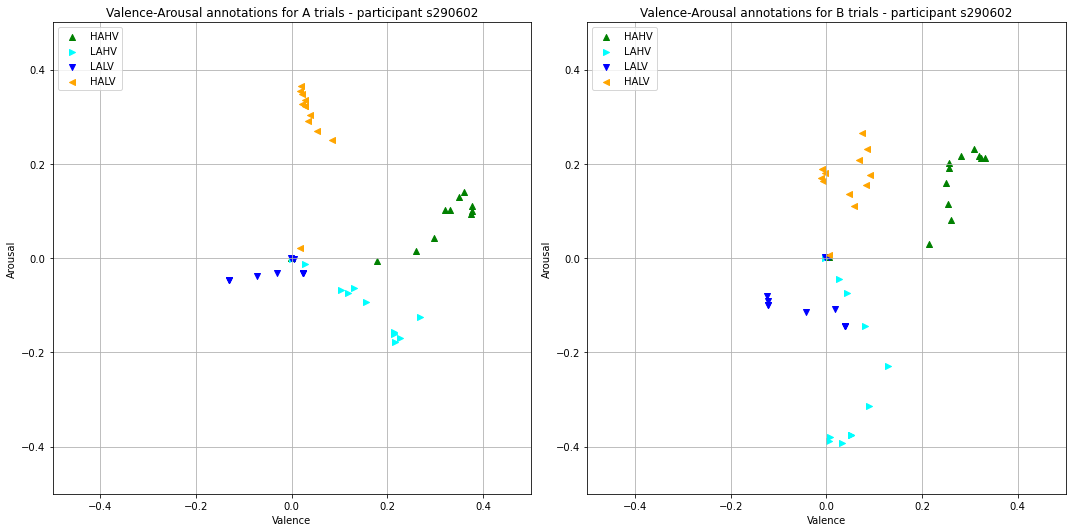

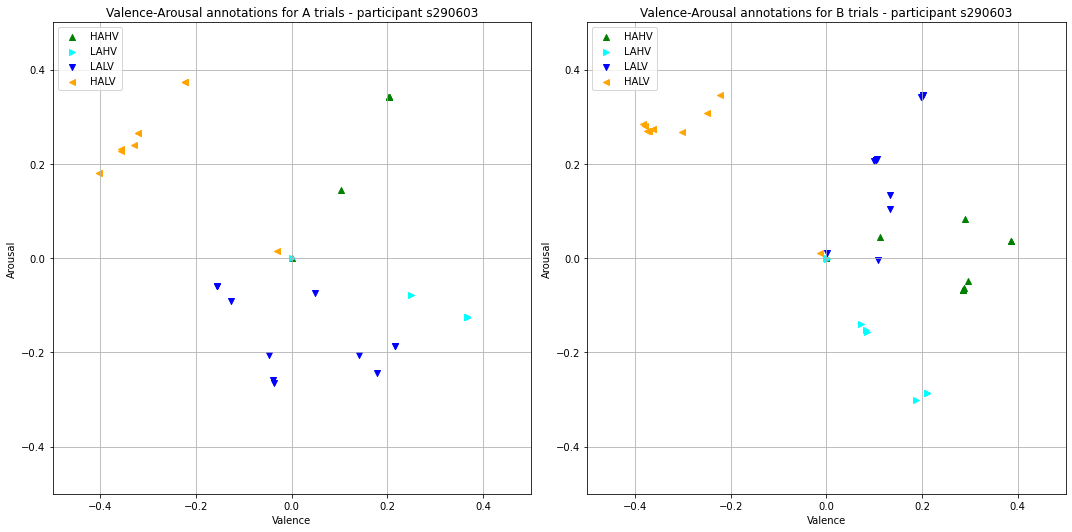

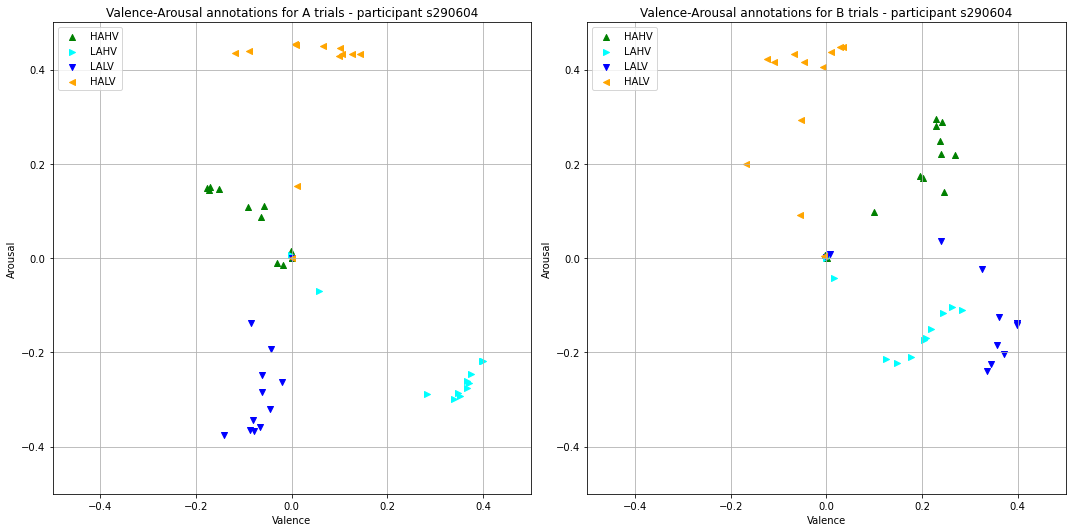

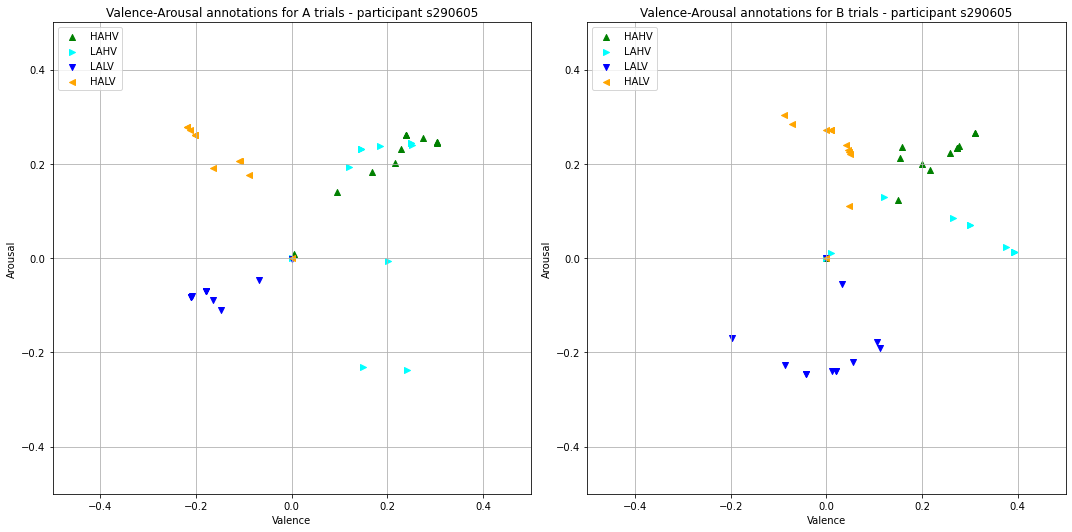

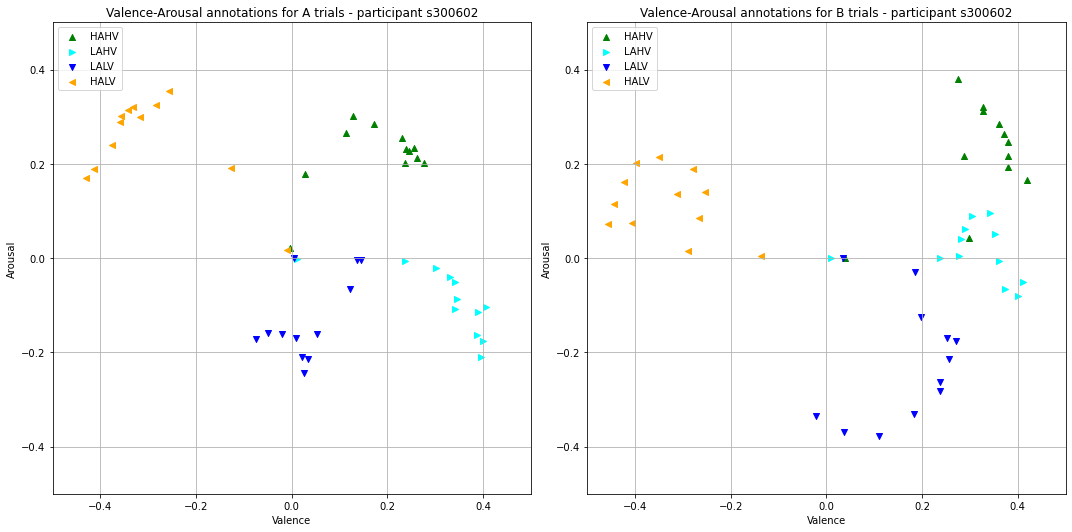

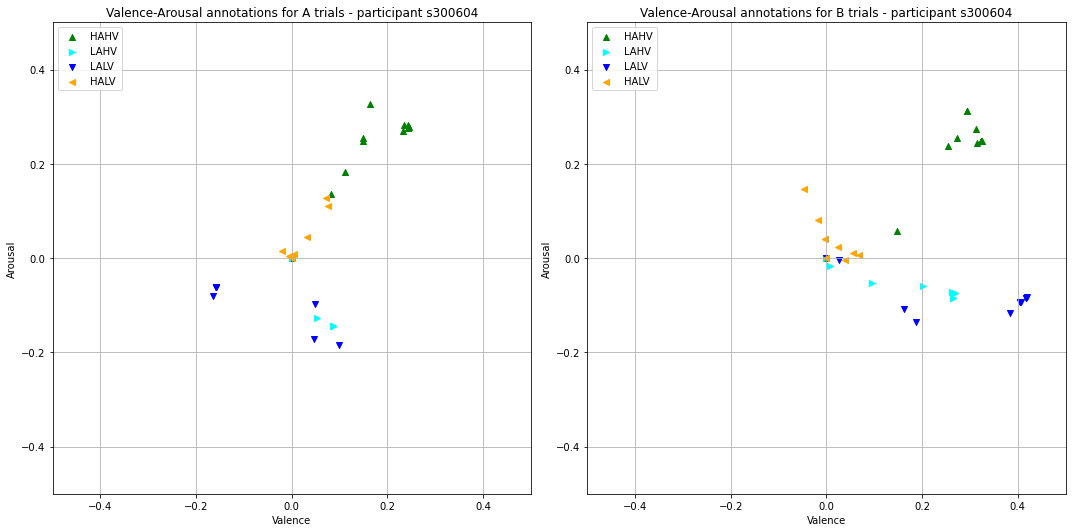

In [60]:
# Use ONLY to visualize the annotations
n_windows = 60 / window_size
for participant_id in prep_dataset:
    prep_dataset[participant_id] = participant_avg_annotation_windows(prep_dataset[participant_id], n_windows)
    plot_avg_annotations(prep_dataset[participant_id])


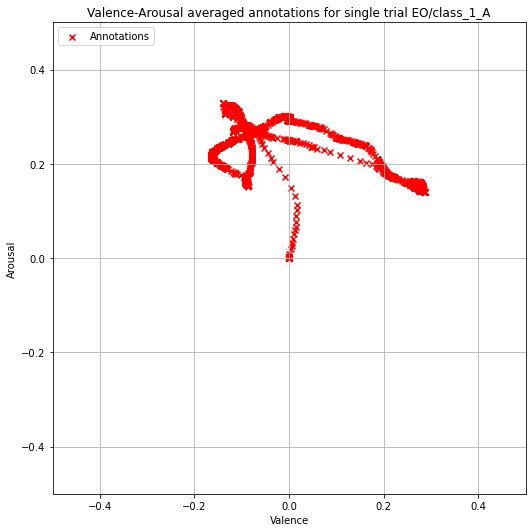

In [11]:
# Single trial annotations plotting
participant_id = 's010701'
trial_label = 'EO/class_1_A'
x = dataset[participant_id]['trials'][trial_label]['annotations']['x']
y = dataset[participant_id]['trials'][trial_label]['annotations']['y']
plot_trial_annotations(x, y, trial_label, animated=False)

<IPython.core.display.Javascript object>


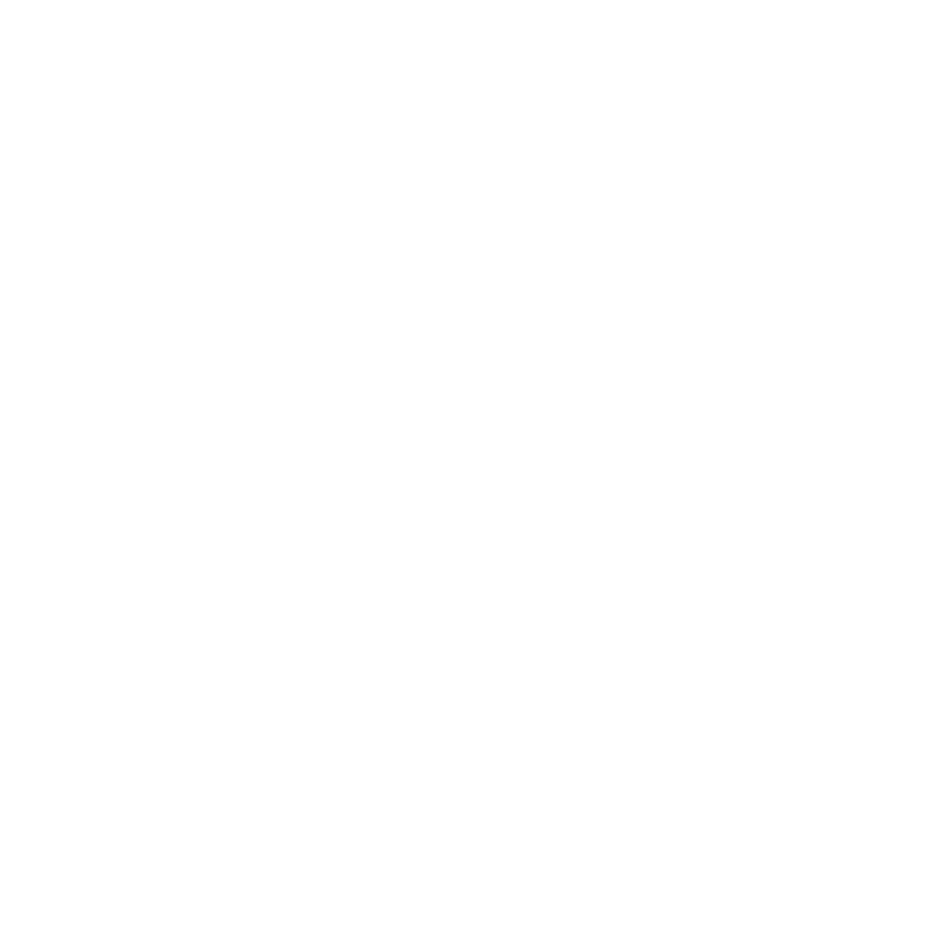

In [30]:
%matplotlib notebook
# Animated trial annotations plotting

participant_id = 's010701'
trial_label = 'EO/class_3_A'
valence = dataset[participant_id]['trials'][trial_label]['annotations']['x']
arousal = dataset[participant_id]['trials'][trial_label]['annotations']['y']
marker = 'x'
color = 'red'
label = 'Annotations'
if trial_label.__contains__('class_1'):
    marker = '^'
    color = 'green'
    label= 'HAHV'
if trial_label.__contains__('class_2'):
    marker = '>'
    color = 'cyan'
    label= 'LAHV'
if trial_label.__contains__('class_3'):
    marker = 'v'
    color = 'blue'
    label= 'LALV'
if trial_label.__contains__('class_4'):
    marker = '<'
    color = 'orange'
    label= 'HALV'
    
fig, ax = plt.subplots()
x, y = [],[]
sc = ax.scatter(x, y, c=color, marker=marker, label=label)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.grid(True)
def animate(i):
    x.append(valence[i])
    y.append(arousal[i])
    sc.set_offsets(np.c_[x,y])

ani = matplotlib.animation.FuncAnimation(fig, animate, 
                frames=len(valence), interval=10, repeat=True, blit=True) 
plt.show()

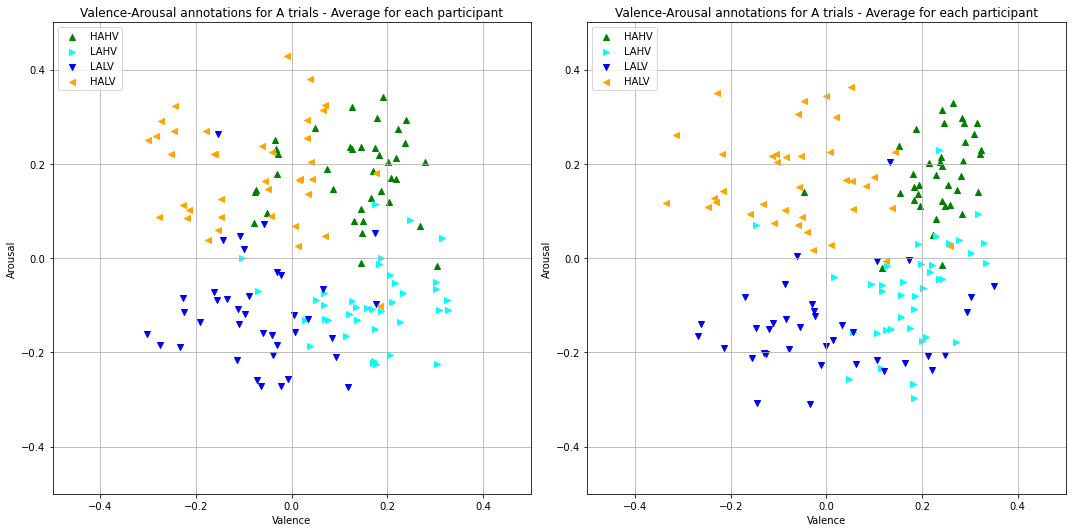

In [4]:
plot_avg_annotations_all_participants(prep_dataset)


Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.01714463]]
Mean squared error: 0.01
Coefficient of determination: -0.07


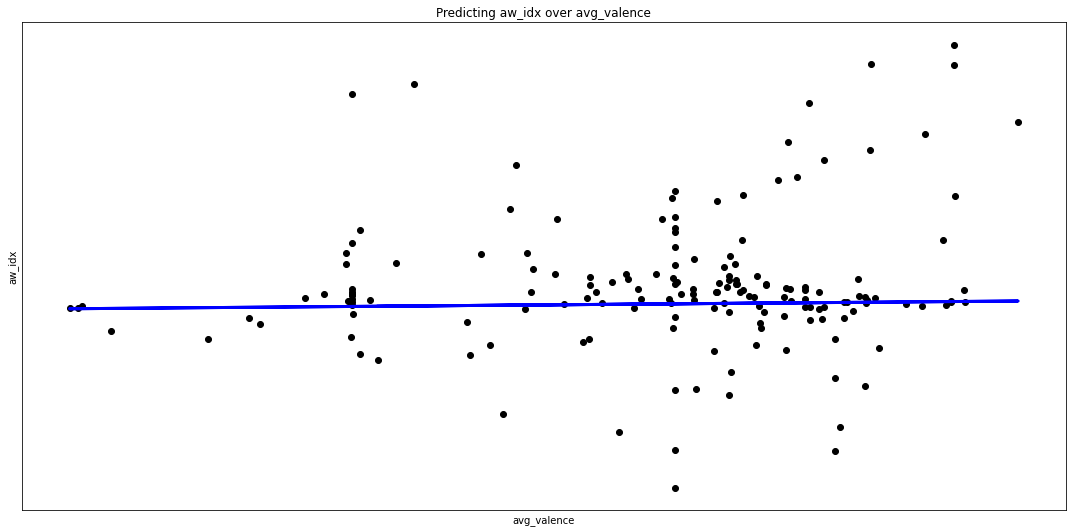

(0.008778210620830344, array([[0.01714463]]), -0.0678166561508009)

In [51]:
# AW Index and Valence
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)

train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]

plt.rcParams["figure.figsize"] = [15, 7.50]
independent = 'avg_valence'
dependent = 'aw_idx'
condition = 'EC'
trial_class = 'class_1_'
x_train, y_train, x_test, y_test = valence_and_neuromarker(prep_dataset=prep_dataset, train_participants=train_participants, test_participants=test_participants, trial_class=trial_class, condition=condition, neuromarker=dependent)
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=True)

Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[-0.05048146]]
Mean squared error: 0.01
Coefficient of determination: -0.08


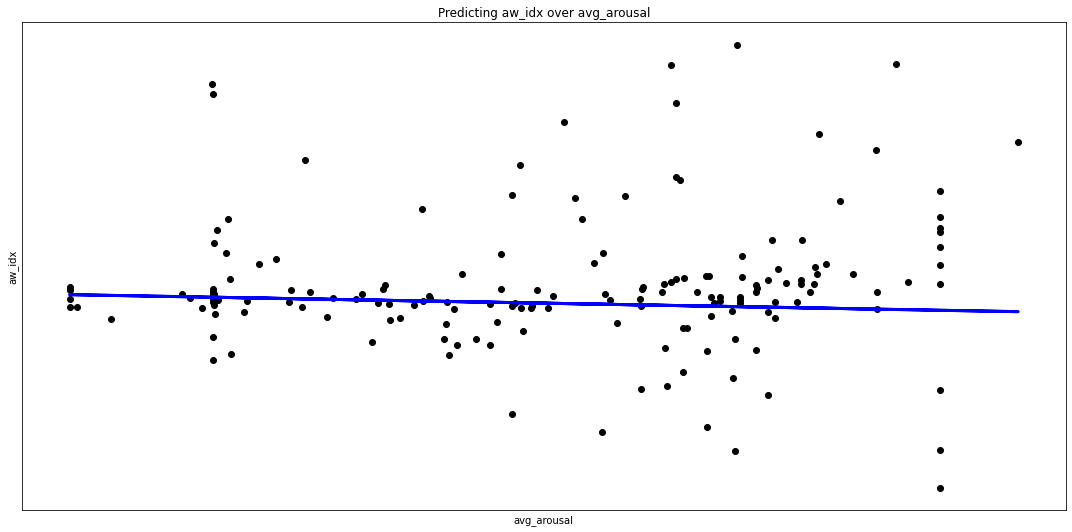

(0.008882642565988771, array([[-0.05048146]]), -0.08052017572798875)

In [27]:
# AW Index and Arousal
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)

train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]

plt.rcParams["figure.figsize"] = [15, 7.50]
independent = 'avg_arousal'
dependent = 'aw_idx'
condition = 'EC'
trial_class = 'class_1_'
x_train, y_train, x_test, y_test = arousal_and_neuromarker(prep_dataset=prep_dataset, train_participants=train_participants, test_participants=test_participants, trial_class=trial_class, condition=condition, neuromarker=dependent)
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=True)

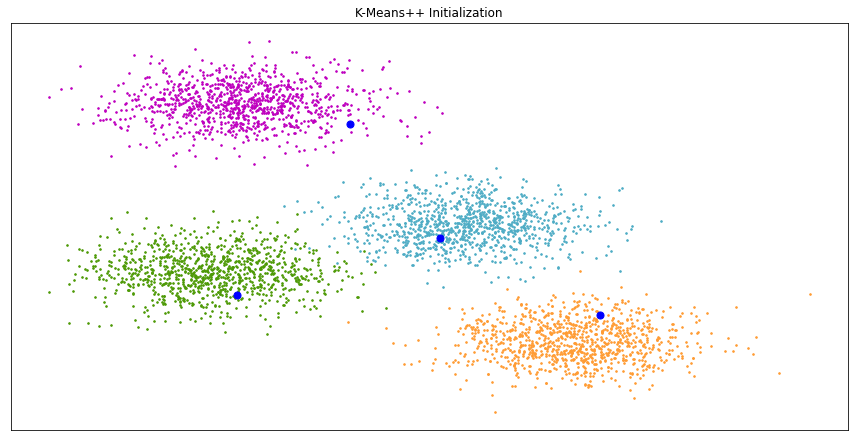

In [58]:
from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate sample data
n_samples = 4000
n_components = 4

X, y_true = make_blobs(n_samples=n_samples,
                       centers=n_components,
                       cluster_std=0.60,
                       random_state=0)


# Calculate seeds from kmeans++
centers_init, indices = kmeans_plusplus(X, n_clusters=4,
                                        random_state=0)

# Plot init seeds along side sample data
plt.figure(1)
colors = ['#4EACC5', '#FF9C34', '#4E9A06', 'm']

for k, col in enumerate(colors):
    cluster_data = y_true == k
    plt.scatter(X[cluster_data, 0], X[cluster_data, 1],
                c=col, marker='.', s=10)

plt.scatter(centers_init[:, 0], centers_init[:, 1], c='b', s=50)
plt.title("K-Means++ Initialization")
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
# Linear Regression for liking and familiarity
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)

train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]

independent = 'familiarity'
dependent = 'liking'
condition = 'EC'
trial_class = 'class_3_'

x_train, y_train, x_test, y_test = liking_familiarity_correlation(prep_dataset, train_participants, test_participants, condition, trial_class, dependent, independent)


In [25]:
# Single participant regression

X = np.array([])
y = np.array([])
independent = 'avg_valence'
dependent = 'aw_idx'
participant_id = 's010703'
neuromarker = 'aw_idx'
condition = 'EO'
trial_class = 'class_1_'

idx = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features'][neuromarker]
avg_valence = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'A']['features']['avg_x']
X = np.concatenate((X, np.array(avg_valence)))
y = np.concatenate((y, np.array(idx)))

idx = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features'][neuromarker]
avg_valence = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'B']['features']['avg_x']
X = np.concatenate((X, np.array(avg_valence)))
y = np.concatenate((y, np.array(idx)))

x_train, x_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)

(19,)
(19,)
(5,)
(5,)
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[-0.51411264]]
Mean squared error: 0.02
Coefficient of determination: -0.46


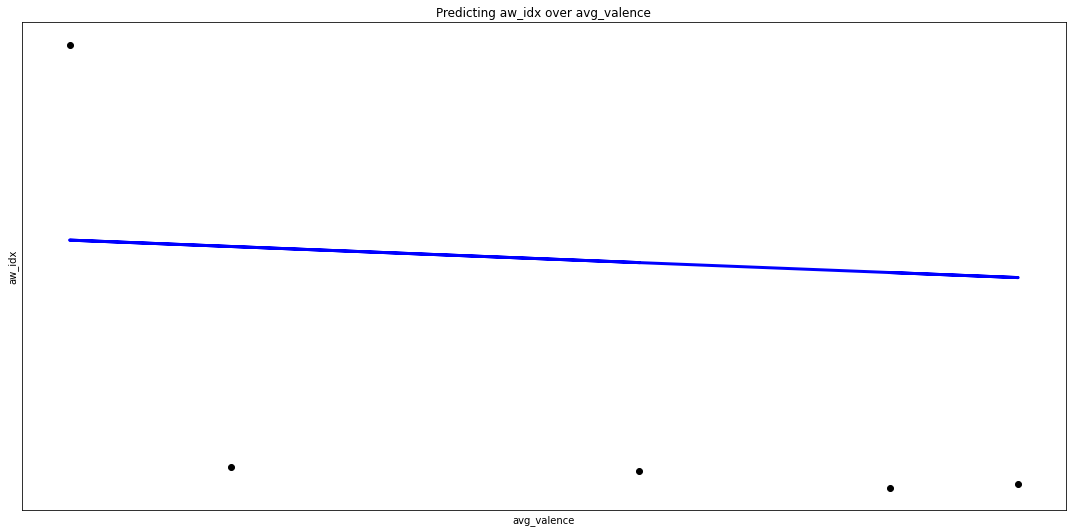

(0.024722297136492592, array([[-0.51411264]]), -0.4596655437848052)

In [26]:
# https://stackoverflow.com/questions/40941542/using-scikit-learn-linearregression-to-plot-a-linear-fit
plt.rcParams["figure.figsize"] = [15, 7.50]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=True)

### Automated Analysis
Now that we have the methods, we can automate the linear regression for all conditions and all classes

Analyzing condition EC for class_1_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.01766296]]
Mean squared error: 0.01
Coefficient of determination: -0.04


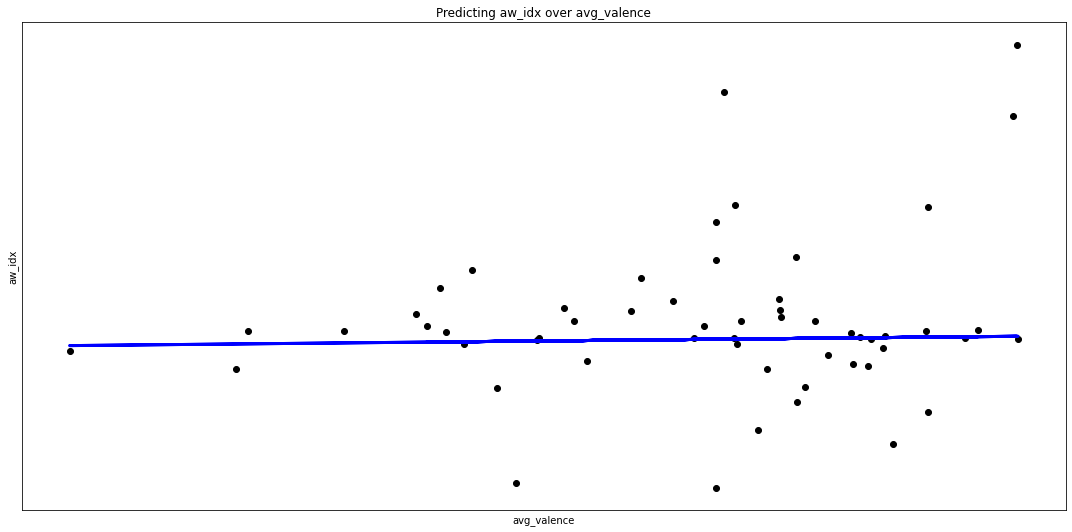

Analyzing condition EC for class_2_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.03280256]]
Mean squared error: 0.01
Coefficient of determination: -0.20


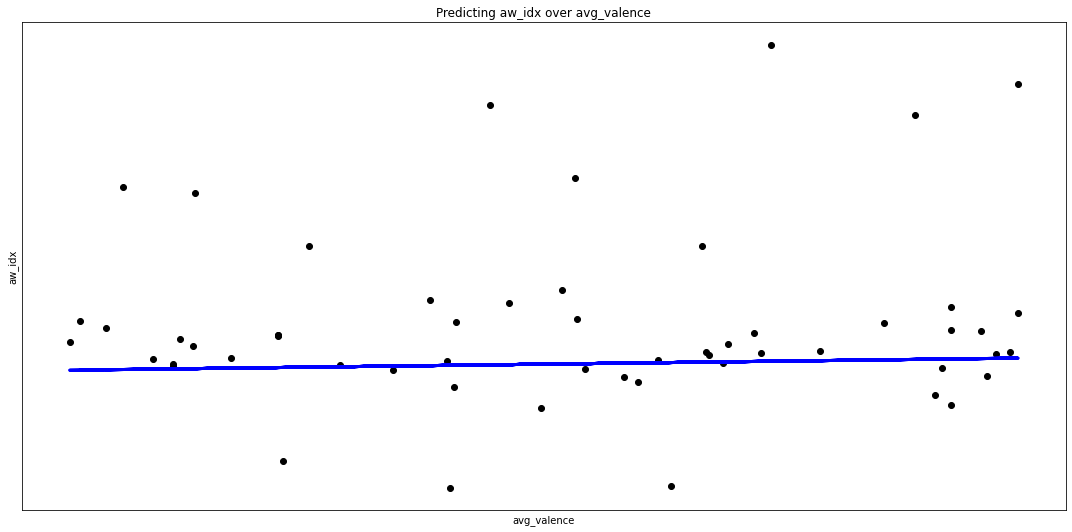

Analyzing condition EC for class_3_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.02772099]]
Mean squared error: 0.01
Coefficient of determination: -0.12


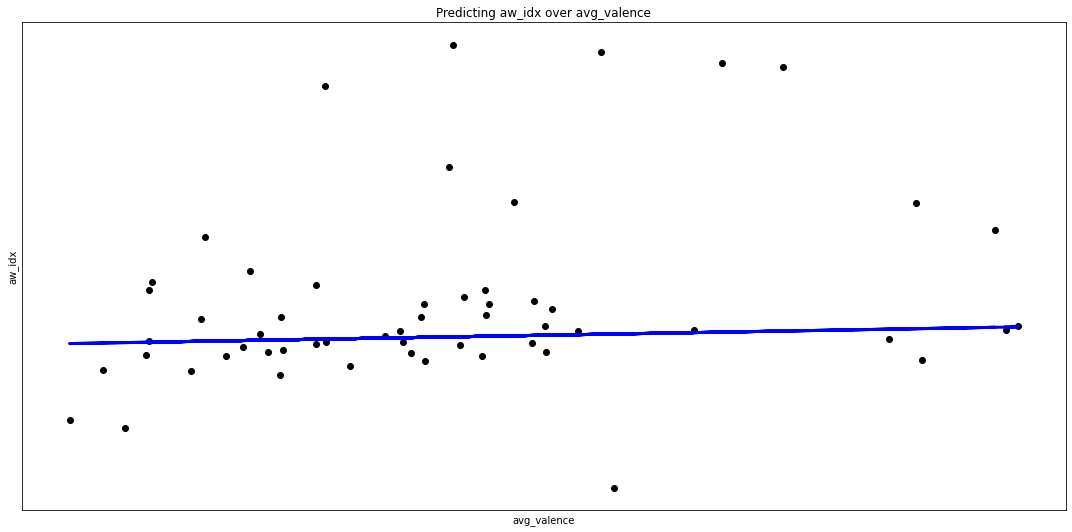

Analyzing condition EC for class_4_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.04164274]]
Mean squared error: 0.01
Coefficient of determination: -0.11


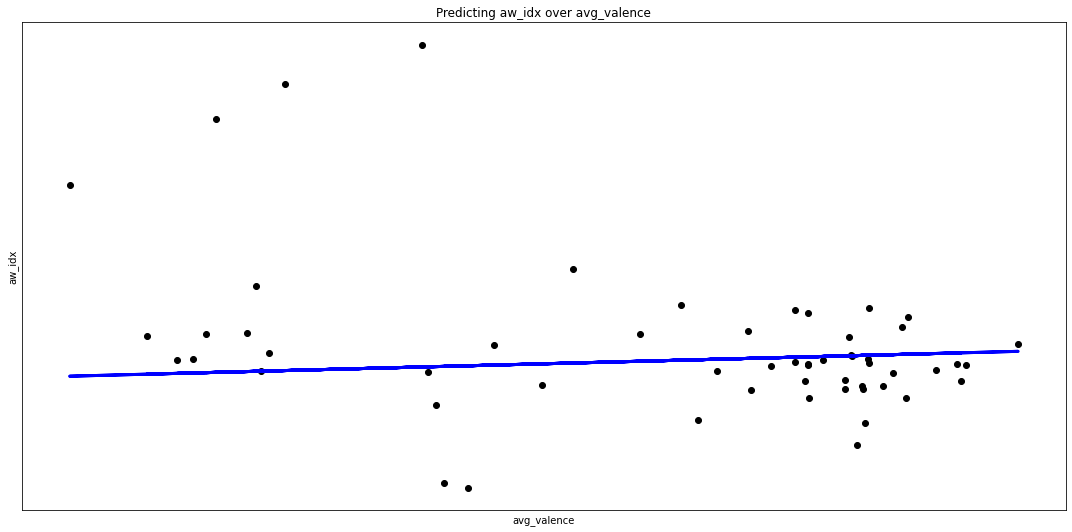

Analyzing condition EO for class_1_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.06820659]]
Mean squared error: 0.01
Coefficient of determination: -0.13


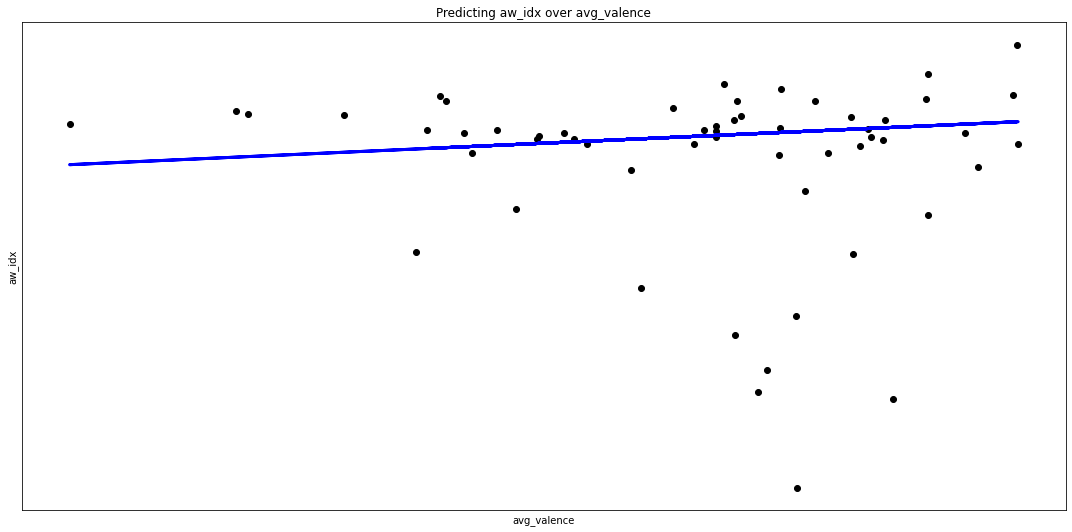

Analyzing condition EO for class_2_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.06139344]]
Mean squared error: 0.01
Coefficient of determination: -0.01


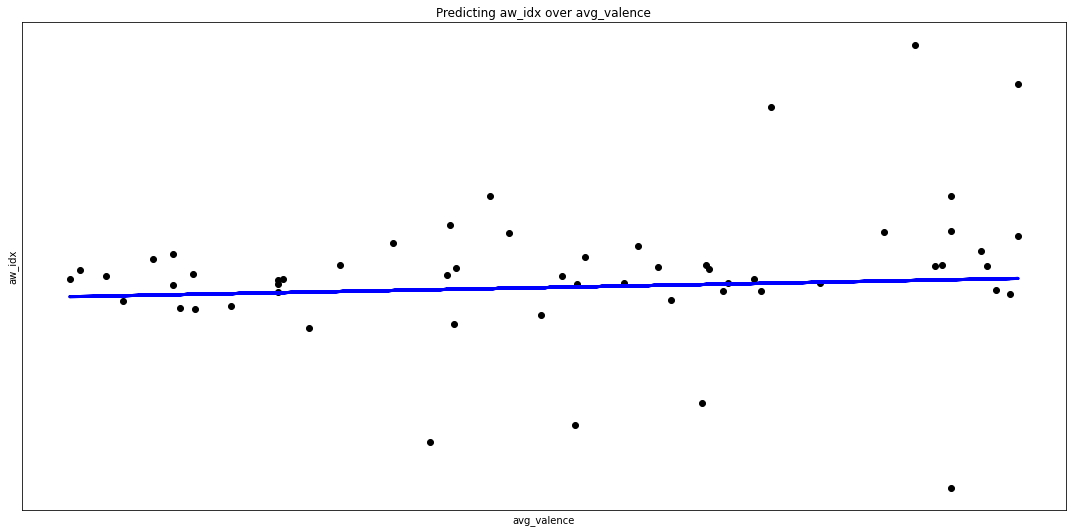

Analyzing condition EO for class_3_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.00290055]]
Mean squared error: 0.01
Coefficient of determination: -0.03


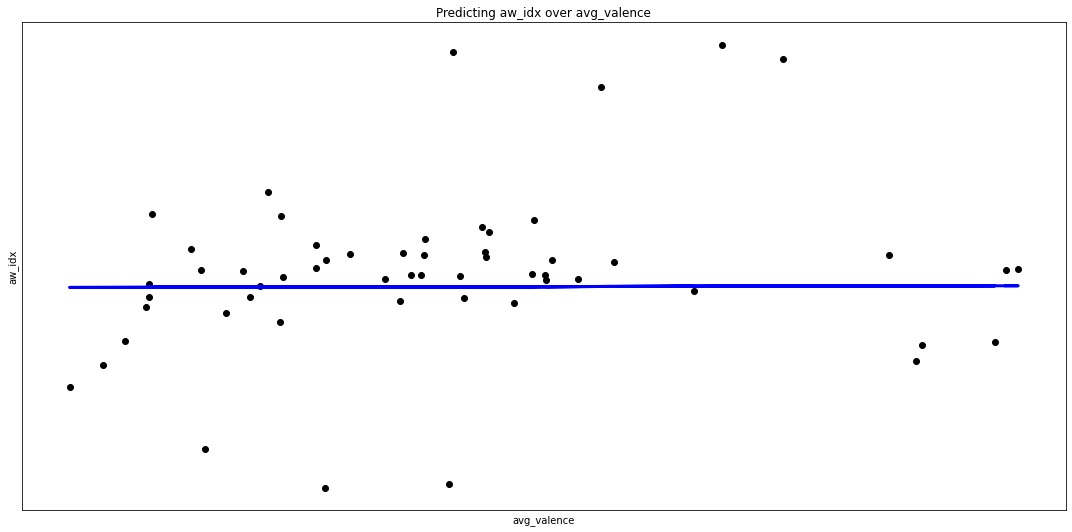

Analyzing condition EO for class_4_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.02261505]]
Mean squared error: 0.01
Coefficient of determination: -0.04


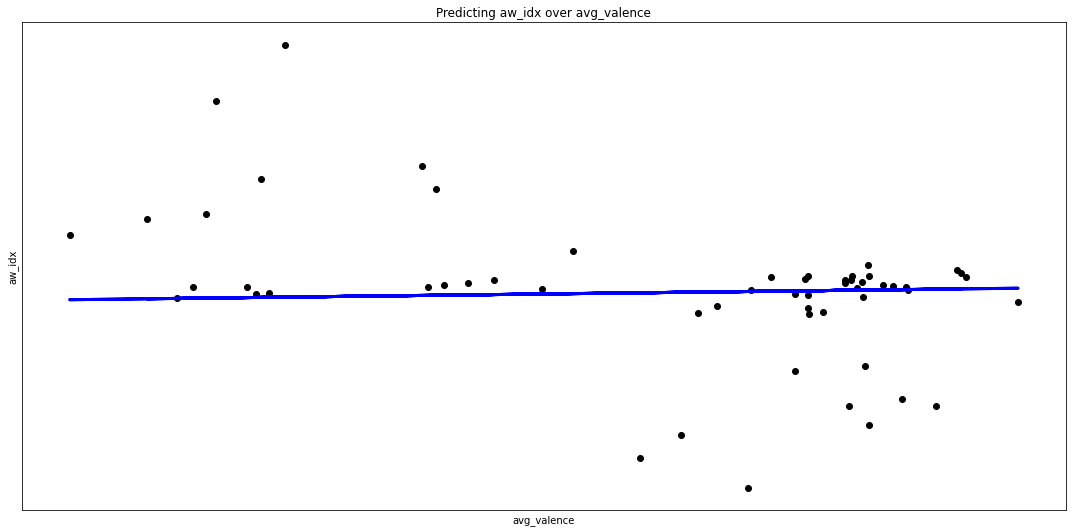

In [35]:
# AW Index with Valence
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)
train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]

plt.rcParams["figure.figsize"] = [15, 7.50]
dependent = 'aw_idx'
conditions = ['EC', 'EO']
trial_classes = ['class_1_', 'class_2_', 'class_3_', 'class_4_']
independent = 'avg_valence'
dependent = 'aw_idx'
for condition in conditions:
    for trial_class in trial_classes:
        print("Analyzing condition " + condition + " for " + trial_class)
        x_train, y_train, x_test, y_test = valence_and_neuromarker(prep_dataset=prep_dataset, train_participants=train_participants, test_participants=test_participants, trial_class=trial_class, condition=condition, neuromarker=dependent)
        x_train = x_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
        lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=True)

Analyzing condition EC for class_1_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[-0.06623806]]
Mean squared error: 0.01
Coefficient of determination: -0.06


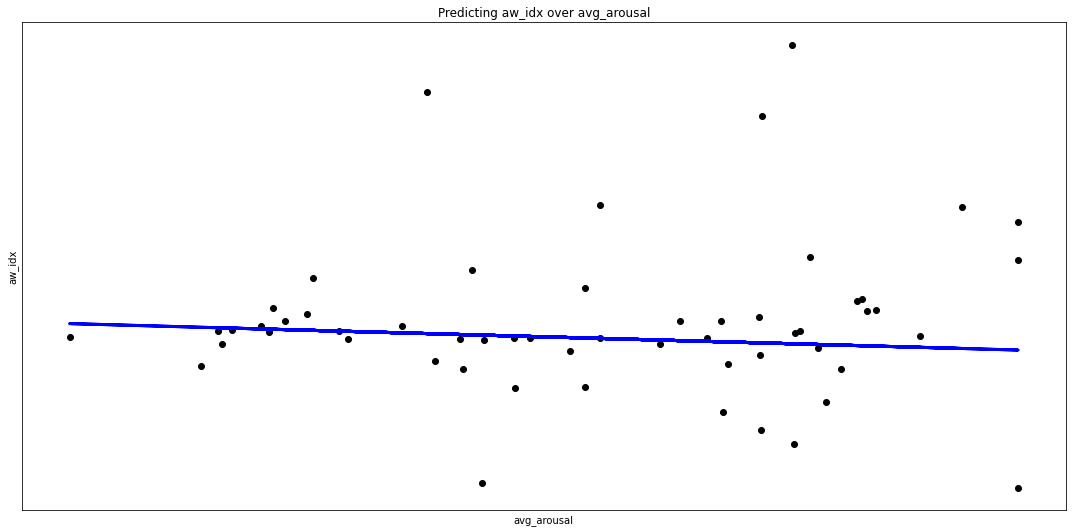

Analyzing condition EC for class_2_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[-0.05629864]]
Mean squared error: 0.01
Coefficient of determination: -0.20


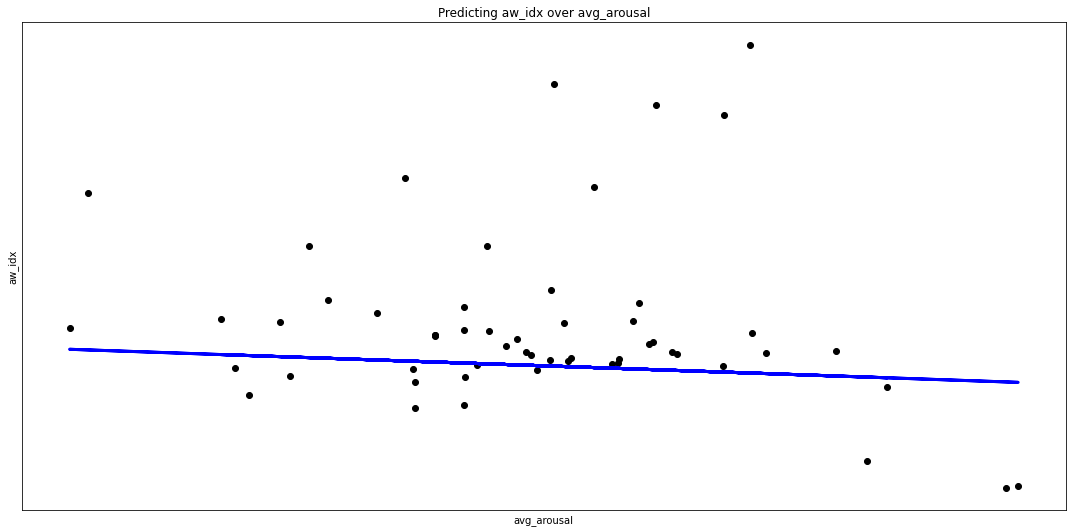

Analyzing condition EC for class_3_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[-0.07129659]]
Mean squared error: 0.01
Coefficient of determination: -0.15


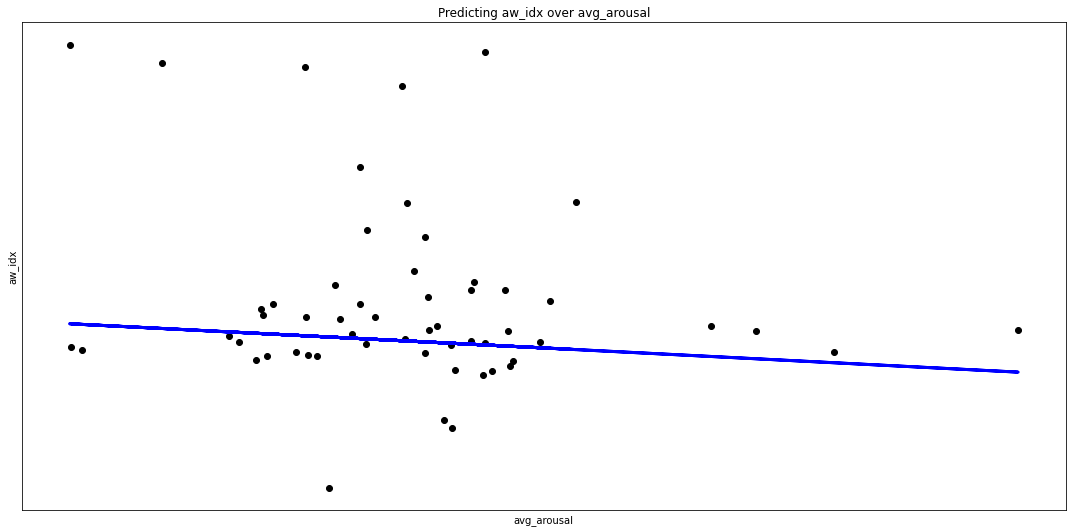

Analyzing condition EC for class_4_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[0.02891672]]
Mean squared error: 0.01
Coefficient of determination: -0.05


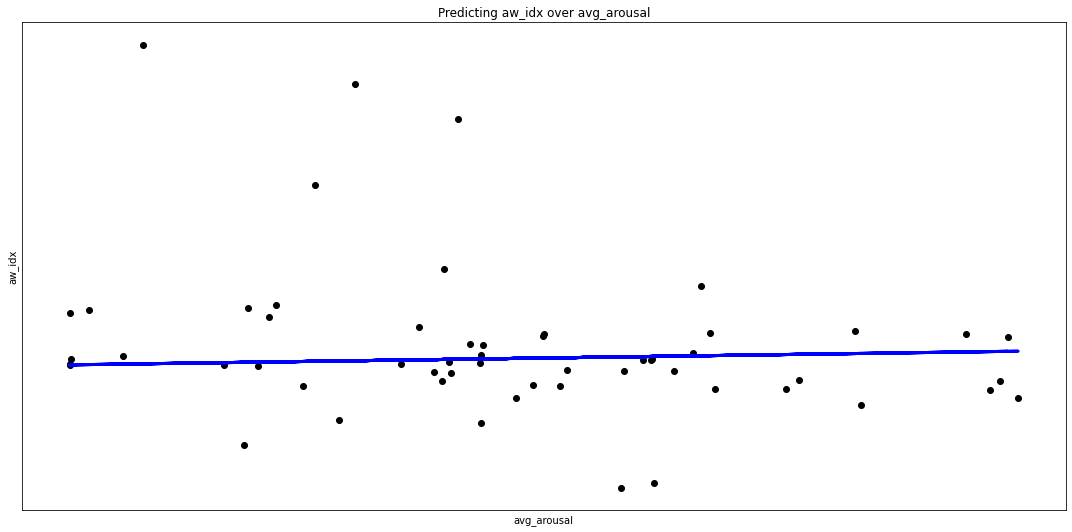

Analyzing condition EO for class_1_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[-0.03461389]]
Mean squared error: 0.01
Coefficient of determination: -0.08


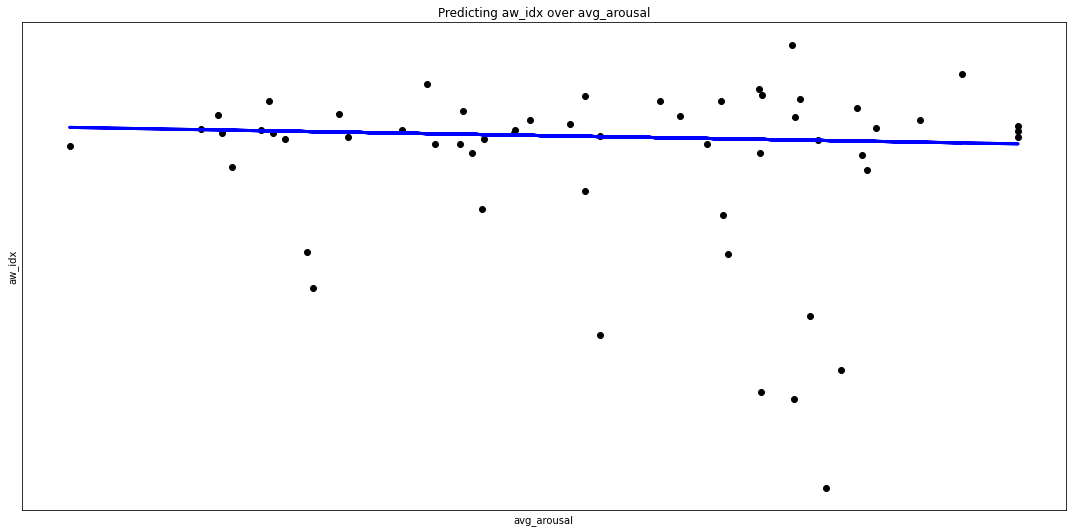

Analyzing condition EO for class_2_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[0.01235052]]
Mean squared error: 0.01
Coefficient of determination: -0.04


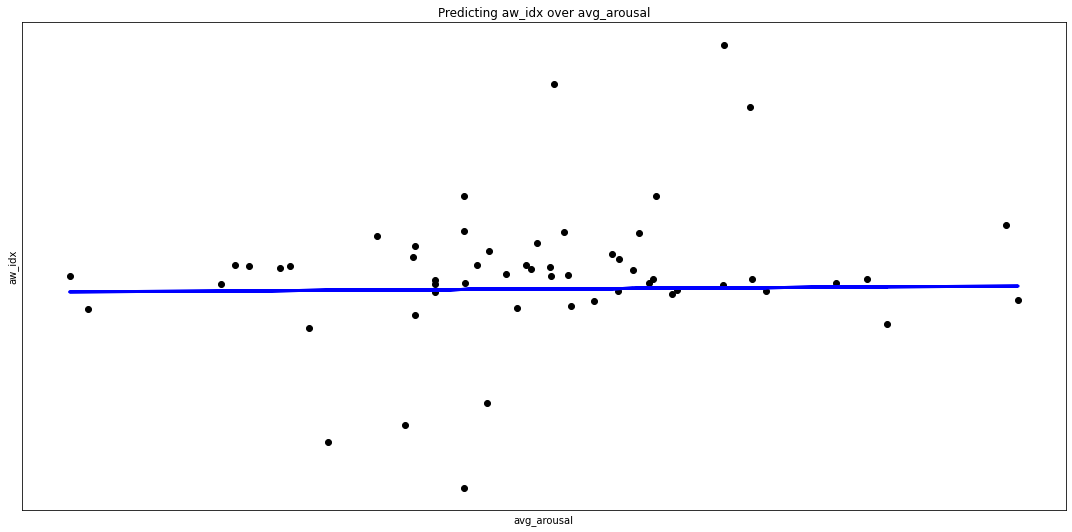

Analyzing condition EO for class_3_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[-0.00508294]]
Mean squared error: 0.01
Coefficient of determination: -0.03


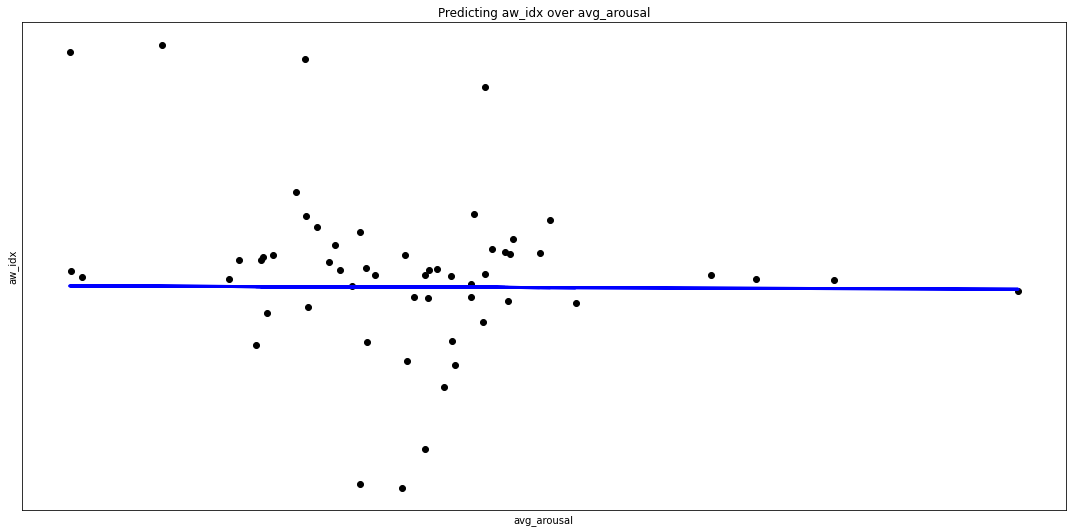

Analyzing condition EO for class_4_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[0.00870967]]
Mean squared error: 0.01
Coefficient of determination: -0.00


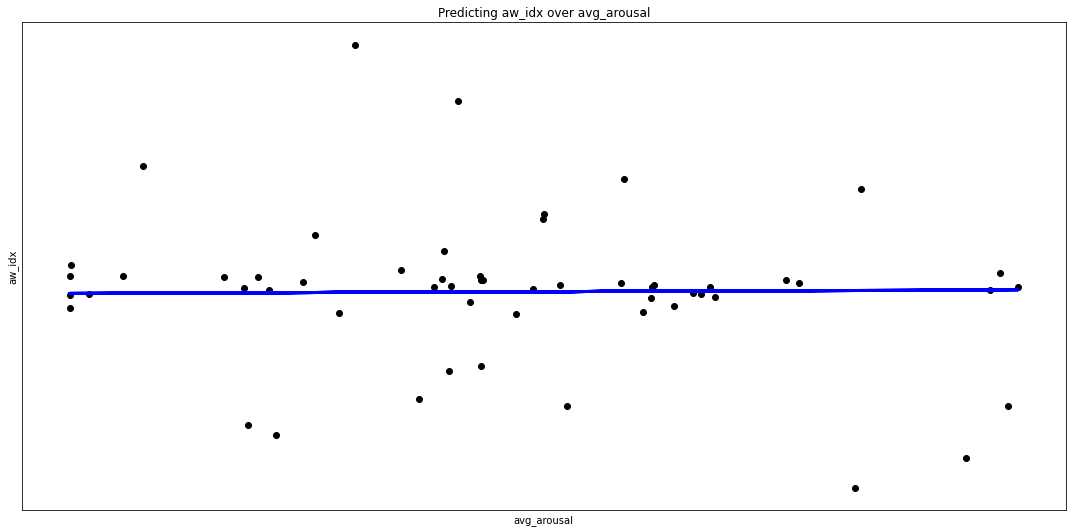

In [36]:
# AW Index with Arousal
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)
train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]

plt.rcParams["figure.figsize"] = [15, 7.50]
dependent = 'aw_idx'
conditions = ['EC', 'EO']
trial_classes = ['class_1_', 'class_2_', 'class_3_', 'class_4_']
independent = 'avg_arousal'
dependent = 'aw_idx'
for condition in conditions:
    for trial_class in trial_classes:
        print("Analyzing condition " + condition + " for " + trial_class)
        x_train, y_train, x_test, y_test = arousal_and_neuromarker(prep_dataset=prep_dataset, train_participants=train_participants, test_participants=test_participants, trial_class=trial_class, condition=condition, neuromarker=dependent)
        x_train = x_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
        lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=True)

In [ ]:
# Liking and familiarity
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)
train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]

plt.rcParams["figure.figsize"] = [15, 7.50]
dependent = 'aw_idx'
conditions = ['EC', 'EO']
trial_classes = ['class_1_', 'class_2_', 'class_3_', 'class_4_']
independent = 'familiarity'
dependent = 'liking'
for condition in conditions:
    for trial_class in trial_classes:
        print("Analyzing dependent variable " + dependent + " in correlation with indepentent variable " + independent + " with condition " + condition + " for " + trial_class)
        x_train, y_train, x_test, y_test = liking_familiarity_correlation(prep_dataset, train_participants, test_participants, condition, trial_class, dependent, independent)
        x_train = x_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
        lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=True)

In [ ]:
# Find worst participants
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)
train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]

plt.rcParams["figure.figsize"] = [15, 7.50]
dependent = 'aw_idx'
conditions = ['EC', 'EO']
trial_classes = ['class_1_', 'class_2_', 'class_3_', 'class_4_']
independent = 'avg_valence'
dependent = 'aw_idx'
condition = 'EC'
trial_class = 'class_2_'
for participant in prep_dataset:
    train_participants = participant_keys.copy()
    train_participants.remove(participant)
    test_participants = [participant]
    x_train, y_train, x_test, y_test = valence_and_neuromarker(prep_dataset=prep_dataset, train_participants=train_participants, test_participants=test_participants, trial_class=trial_class, condition=condition, neuromarker=dependent)
    x_train = x_train.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    msq, coef, r2 = lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=False)
    print(participant, "Coeff:", coef)